<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **BERT analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), October 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions to answer: "Does context cue influence METs more than the music itself?"

Analysis approach:
- Works with individual thought descriptions (N=1962) and aggregated documents (called "METdocs")
- Calculates pairwise cosine similarities between all individual thoughts and between METdocs
- Categorises pairs by their stimuli conditions to compare similarity distributions
- Tests whether thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in METs?

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Cloning into 'context-framed-listening'...
remote: Enumerating objects: 539, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 539 (delta 25), reused 74 (delta 6), pack-reused 424 (from 2)
Receiving objects: 100% (539/539), 229.42 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (216/216), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene

Initialise pretrained BERT model and tokeniser:

In [3]:
print("\nLoading BERT model and tokeniser...")
BERTtokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
BERTmodel = BertModel.from_pretrained('bert-base-uncased')
print("BERT model loaded successfully\n")

def get_bert_embedding(text):
    """Get BERT embedding for a single text document using mean pooling."""
    # Tokenise and encode the text
    inputs = BERTtokeniser(text, return_tensors='pt', padding=True,
                           truncation=True, max_length=512)

    # Get BERT outputs
    with torch.no_grad():
        outputs = BERTmodel(**inputs)

    # Use mean pooling across all tokens
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding


Loading BERT model and tokeniser...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT model loaded successfully



---
## ANALYSIS AT COMBINED METdoc LEVEL

Measuring semantic similarity between agregated representations of conditions.

This is a complementary analysis to the individual MET level analyses above.
It aggregates thoughts into documents by clip-context pairs to examine condition-level semantic profiles. This is useful for comparison but the individual-level analysis is the primary approach for hypothesis testing.

Purpose: Compare semantic profiles at the document/condition level
- Each document = all thoughts from one clip-context pairing
- Shows overall semantic "signature" of each condition
- Useful for exploratory visualisation and pattern detection

In [4]:
print("Loading aggregated METdocs...")
# Load the pre-aggregated METdocs file (clip-context level)
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL1.csv')

# Use the BERT-appropriate preprocessing column
text_column = 'METdescr_prepLVL1'

print(f"Total METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")
print(f"Unique genres: {METdocs['genre_code'].nunique()}")

# Display sample
print("\nSample METdocs:")
display(METdocs[['ClipContext_pair', 'clip_name', 'context_word', 'genre_code']].head())

Loading aggregated METdocs...
Total METdocs (clip-context pairs): 64
Unique clips: 16
Unique contexts: 4
Unique genres: 4

Sample METdocs:


,ClipContext_pair,clip_name,context_word,genre_code
0,BAR-80s_LOW_02,80s_LOW_02,bar,80s
1,BAR-80s_LOW_06,80s_LOW_06,bar,80s
2,BAR-80s_MED_08,80s_MED_08,bar,80s
3,BAR-80s_MED_13,80s_MED_13,bar,80s
4,BAR-Ele_LOW_09,Ele_LOW_09,bar,Ele


### BERT embeddings

In [5]:
print("\nComputing BERT embeddings for aggregated METdocs...")

bert_embeddings = []
for idx, row in METdocs.iterrows():
    text = str(row[text_column])
    embedding = get_bert_embedding(text)
    bert_embeddings.append(embedding)

    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(METdocs)} documents...")

bert_embeddings = np.array(bert_embeddings)
print(f"\n✓ BERT embeddings shape: {bert_embeddings.shape}")

# Save embeddings
np.save('/content/context-framed-listening/NLP_outputs/BERT/BERT_embeddings.npy',
        bert_embeddings)


Computing BERT embeddings for aggregated METdocs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

✓ BERT embeddings shape: (64, 768)


### Cosine Similarity Matrix


Calculating cosine similarity matrix...

✓ BERT Cosine Similarity Matrix saved


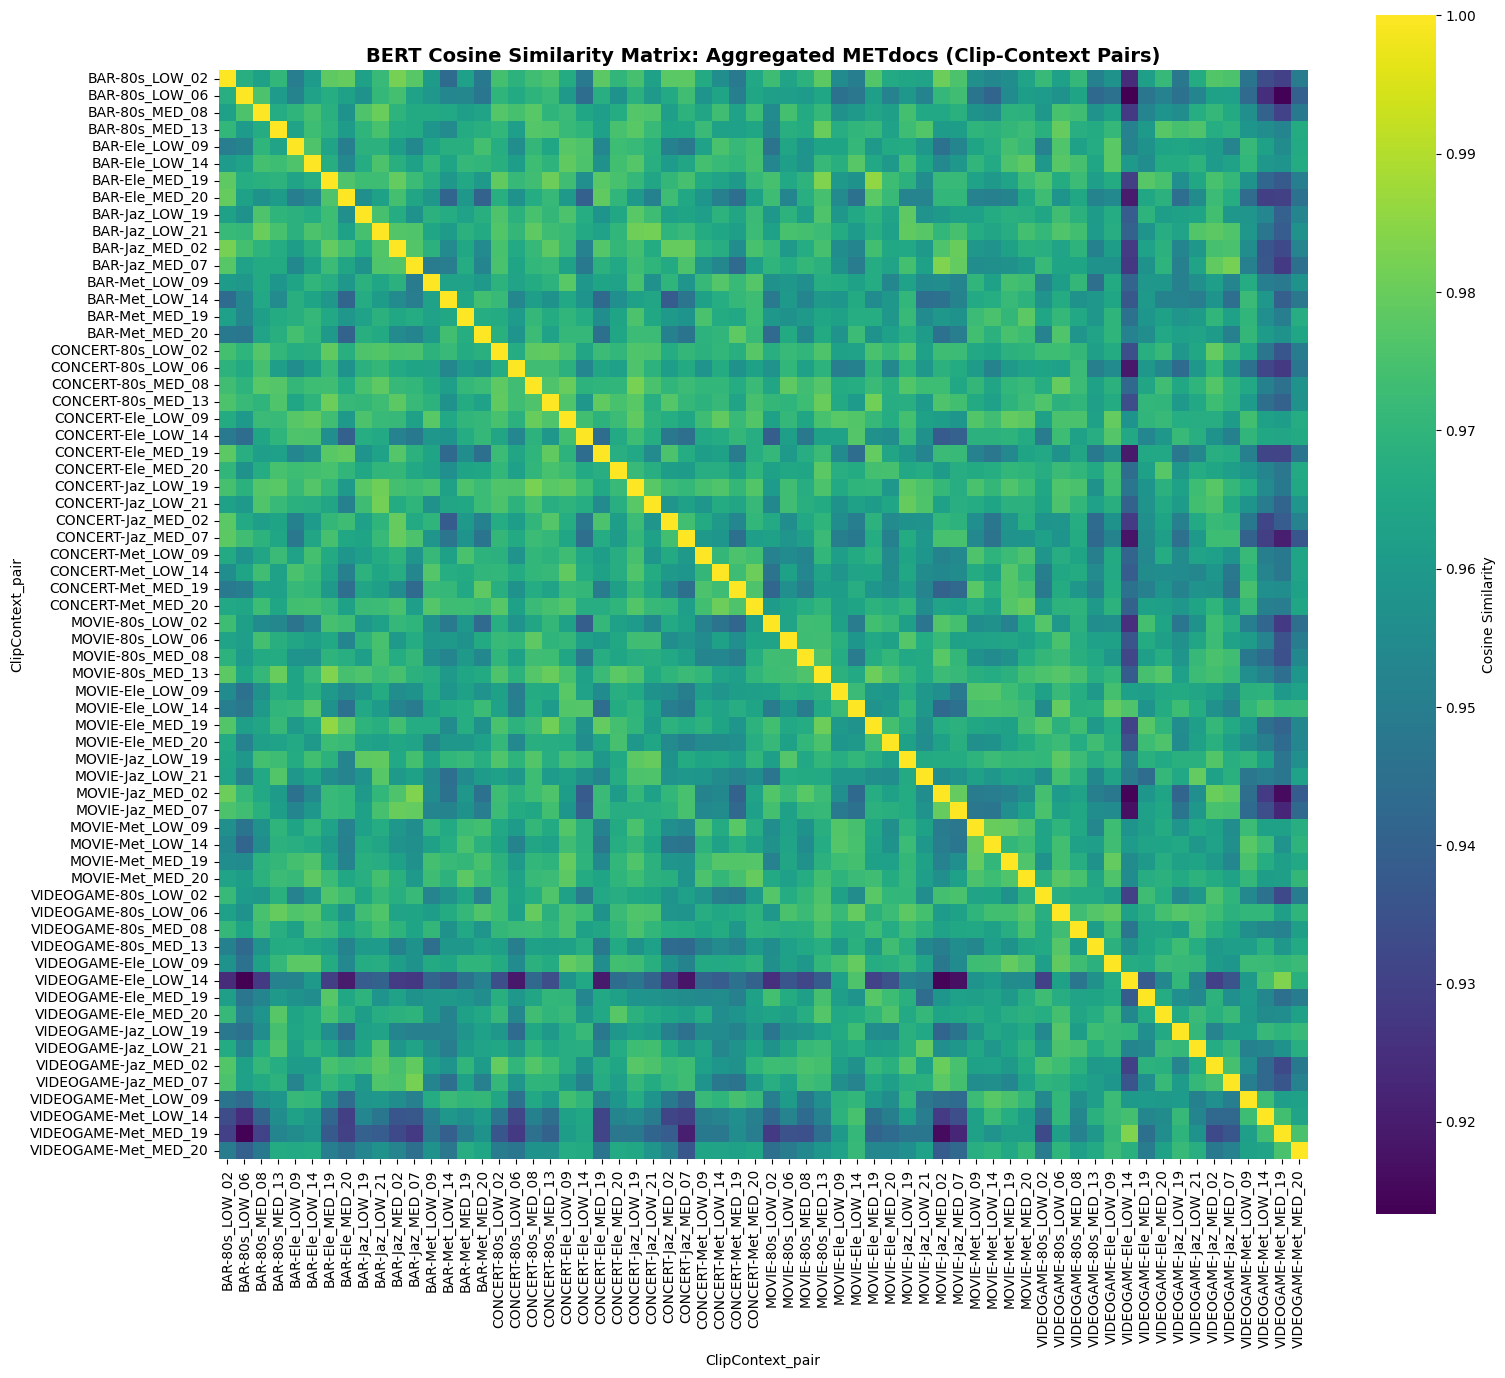

In [6]:
print("\nCalculating cosine similarity matrix...")
cosineMatrix_BERT = cosine_similarity(bert_embeddings, bert_embeddings)

# Create labeled DataFrame
cosineMatrix_BERT_df = pd.DataFrame(
    cosineMatrix_BERT,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save cosine similarity matrix
cosineMatrix_BERT_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/BERT_cosineMatrix.csv',
                             encoding='utf-8')

print("\n✓ BERT Cosine Similarity Matrix saved")

# Visualize similarity matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_BERT_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('BERT Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

### Similarity Values by Condition

In [7]:
print("\nExtracting similarity values by condition...")

# Extract metadata
clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

# Initialise storage for similarity measures
similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

# Iterate through upper triangle of similarity matrix
n_docs = len(METdocs)
print(f"Processing {(n_docs * (n_docs - 1)) // 2} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        # Extract similarity value
        sim_value = cosineMatrix_BERT[i, j]

        # Determine conditions
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # Categorise into conditions
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'
        else:
            condition = 'other'

        # Store data
        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df_docs = pd.DataFrame(similarity_data)
sim_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/BERT/BERT_similarity_by_condition.csv',
                    index=False)

print("\n✓ METdocs-level similarity measures extracted:")
print(sim_df_docs.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values by condition...
Processing 2016 unique document pairs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

✓ METdocs-level similarity measures extracted:
                                   count      mean       std       min  \
condition                                                                
diff_clip_diff_context_diff_genre   1152  0.961045  0.011055  0.913324   
diff_clip_diff_context_same_genre    288  0.965767  0.010162  0.919224   
diff_clip_same_context               480  0.965126  0.009243  0.929710   
same_clip_diff_context                96  0.971750  0.006827  0.950220   

                                        max  
condition                                    
diff_clip_diff_context_diff_genre  0.983408  
diff_clip_diff_context_same_genre  0.983141  
diff_clip_same_context             0.983073  
same

### Binary Comparisons

In [8]:
print("\n" + "="*70)
print("BINARY COMPARISONS - Fundamental Effects")
print("="*70)
print("Testing whether sharing a factor (clip/context/genre) increases similarity")

# ---------------------------------------------------------------------------
# FUNCTION SET-UP
# ---------------------------------------------------------------------------
def compare_binary(df, column, label):
    """Compare same vs different for a binary factor."""
    same_data = df[df[column] == True]['similarity']
    diff_data = df[df[column] == False]['similarity']

    t_stat, p_value = stats.ttest_ind(same_data, diff_data)
    pooled_std = np.sqrt((same_data.std()**2 + diff_data.std()**2) / 2)
    effect_size = (same_data.mean() - diff_data.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"Same {label} vs Different {label}",
        'mean_same': same_data.mean(),
        'mean_diff': diff_data.mean(),
        'diff': same_data.mean() - diff_data.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n_same': len(same_data),
        'n_diff': len(diff_data)
    }


binary_comparisons = []

# 1. CLIP EFFECT
print("\n1. CLIP EFFECT: Same Clip vs Different Clip")
print("-" * 70)
clip_comp = compare_binary(sim_df_docs, 'same_clip', 'Clip')
binary_comparisons.append(clip_comp)

print(f"Same clip: M={clip_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_same']})")
print(f"Different clip: M={clip_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_diff']})")
print(f"Difference: {clip_comp['diff']:.4f}")
print(f"t({clip_comp['n_same'] + clip_comp['n_diff'] - 2}) = {clip_comp['t']:.3f}, p = {clip_comp['p']:.4f} {clip_comp['sig']}")
print(f"Cohen's d = {clip_comp['d']:.3f}")

if clip_comp['mean_same'] > clip_comp['mean_diff']:
    print("→ Sharing the same CLIP significantly increases similarity")
else:
    print("→ Same clip does NOT significantly increase similarity")

# 2. CONTEXT EFFECT
print("\n\n2. CONTEXT EFFECT: Same Context vs Different Context")
print("-" * 70)
context_comp = compare_binary(sim_df_docs, 'same_context', 'Context')
binary_comparisons.append(context_comp)

print(f"Same context: M={context_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_same']})")
print(f"Different context: M={context_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_diff']})")
print(f"Difference: {context_comp['diff']:.4f}")
print(f"t({context_comp['n_same'] + context_comp['n_diff'] - 2}) = {context_comp['t']:.3f}, p = {context_comp['p']:.4f} {context_comp['sig']}")
print(f"Cohen's d = {context_comp['d']:.3f}")

if context_comp['mean_same'] > context_comp['mean_diff']:
    print("→ Sharing the same CONTEXT significantly increases similarity")
else:
    print("→ Same context does NOT significantly increase similarity")

# 3. GENRE EFFECT
print("\n\n3. GENRE EFFECT: Same Genre vs Different Genre")
print("-" * 70)
genre_comp = compare_binary(sim_df_docs, 'same_genre', 'Genre')
binary_comparisons.append(genre_comp)

print(f"Same genre: M={genre_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_same']})")
print(f"Different genre: M={genre_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_diff']})")
print(f"Difference: {genre_comp['diff']:.4f}")
print(f"t({genre_comp['n_same'] + genre_comp['n_diff'] - 2}) = {genre_comp['t']:.3f}, p = {genre_comp['p']:.4f} {genre_comp['sig']}")
print(f"Cohen's d = {genre_comp['d']:.3f}")

if genre_comp['mean_same'] > genre_comp['mean_diff']:
    print("→ Sharing the same GENRE significantly increases similarity")
else:
    print("→ Same genre does NOT significantly increase similarity")

# KEY COMPARISON
print("\n\n" + "="*70)
print("KEY FINDING: Comparing Binary Effects")
print("="*70)

effects = [
    ('CLIP', clip_comp['d'], clip_comp['diff']),
    ('CONTEXT', context_comp['d'], context_comp['diff']),
    ('GENRE', genre_comp['d'], genre_comp['diff'])
]
effects_sorted = sorted(effects, key=lambda x: abs(x[1]), reverse=True)

print("\nEffect sizes ranked (absolute Cohen's d):")
for i, (factor, d, diff) in enumerate(effects_sorted, 1):
    print(f"  {i}. {factor}: d = {d:.3f}, mean difference = {diff:.4f}")

print(f"\n→ {effects_sorted[0][0]} has the LARGEST effect on thought similarity")
print(f"→ {effects_sorted[1][0]} has a MODERATE effect")
print(f"→ {effects_sorted[2][0]} has the SMALLEST effect")


BINARY COMPARISONS - Fundamental Effects
Testing whether sharing a factor (clip/context/genre) increases similarity

1. CLIP EFFECT: Same Clip vs Different Clip
----------------------------------------------------------------------
Same clip: M=0.9718, SD=0.0068 (N=96)
Different clip: M=0.9628, SD=0.0107 (N=1920)
Difference: 0.0090
t(2014) = 8.133, p = 0.0000 ***
Cohen's d = 1.000
→ Sharing the same CLIP significantly increases similarity


2. CONTEXT EFFECT: Same Context vs Different Context
----------------------------------------------------------------------
Same context: M=0.9651, SD=0.0092 (N=480)
Different context: M=0.9626, SD=0.0111 (N=1536)
Difference: 0.0025
t(2014) = 4.527, p = 0.0000 ***
Cohen's d = 0.248
→ Sharing the same CONTEXT significantly increases similarity


3. GENRE EFFECT: Same Genre vs Different Genre
----------------------------------------------------------------------
Same genre: M=0.9675, SD=0.0095 (N=480)
Different genre: M=0.9619, SD=0.0107 (N=1536)
Dif

#### Visualization

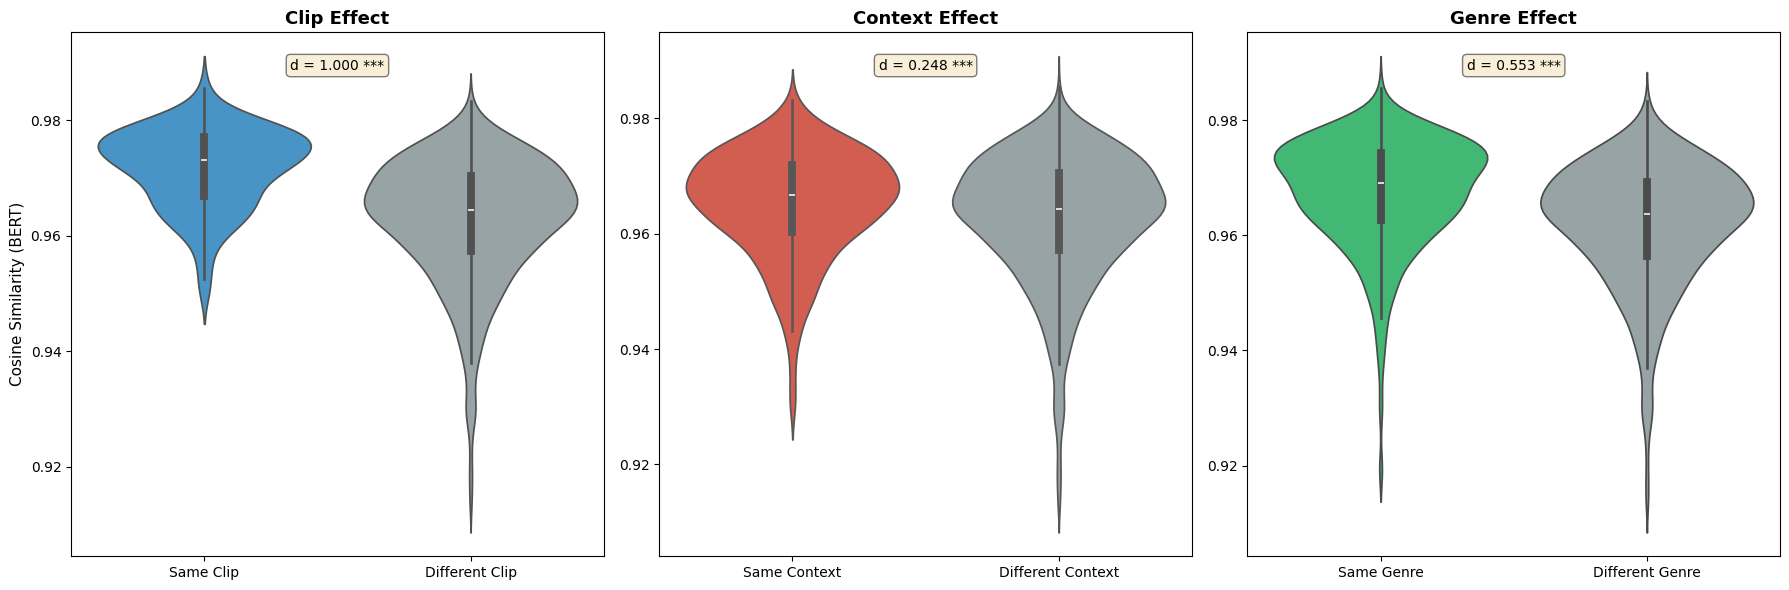


✓ Binary comparisons visualization saved


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Clip comparison
clip_data = sim_df_docs.copy()
clip_data['clip_label'] = clip_data['same_clip'].map({True: 'Same Clip', False: 'Different Clip'})
sns.violinplot(data=clip_data, x='clip_label', y='similarity',
               order=['Same Clip', 'Different Clip'], ax=axes[0],
               hue='clip_label', palette=['#95a5a6', '#3498db'])
axes[0].set_title('Clip Effect', fontsize=13, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Cosine Similarity (BERT)', fontsize=11)
axes[0].text(0.5, 0.95, f"d = {clip_comp['d']:.3f} {clip_comp['sig']}",
             ha='center', va='top', transform=axes[0].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Context comparison
context_data = sim_df_docs.copy()
context_data['context_label'] = context_data['same_context'].map({True: 'Same Context', False: 'Different Context'})
sns.violinplot(data=context_data, x='context_label', y='similarity',
               order=['Same Context', 'Different Context'], ax=axes[1],
               hue='context_label', palette=['#e74c3c', '#95a5a6'])
axes[1].set_title('Context Effect', fontsize=13, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].text(0.5, 0.95, f"d = {context_comp['d']:.3f} {context_comp['sig']}",
             ha='center', va='top', transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Genre comparison
genre_data = sim_df_docs.copy()
genre_data['genre_label'] = genre_data['same_genre'].map({True: 'Same Genre', False: 'Different Genre'})
sns.violinplot(data=genre_data, x='genre_label', y='similarity',
               order=['Same Genre', 'Different Genre'], ax=axes[2],
               hue='genre_label', palette=['#2ecc71', '#95a5a6'])
axes[2].set_title('Genre Effect', fontsize=13, fontweight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].text(0.5, 0.95, f"d = {genre_comp['d']:.3f} {genre_comp['sig']}",
             ha='center', va='top', transform=axes[2].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_binary_comparisons.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Binary comparisons visualization saved")

### Factor-Specific Analyses

#### Function Set-up

In [10]:
# ---------------------------------------------------------------------------
def analyze_within_factor_similarity(sim_df, metadata, factor_column, factor_name):
    """Analyze within-factor similarity (e.g., same context/genre, different clips)."""
    print(f"\n1. WITHIN-{factor_name.upper()} SIMILARITY")
    print("-" * 70)

    if factor_name == 'Context':
        print("When different music is heard with the same context, how similar are thoughts?")
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        print("When different clips from the same genre are heard, how similar are thoughts?")
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    within_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    for factor in factors:
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            within_results.append({
                factor_name.lower(): factor,
                'mean': factor_sims.mean(),
                'std': factor_sims.std(),
                'n': len(factor_sims),
                'cv': factor_sims.std() / factor_sims.mean()
            })

            print(f"\n{factor.upper()}:")
            print(f"  Mean similarity: {factor_sims.mean():.4f}")
            print(f"  SD: {factor_sims.std():.4f}")
            print(f"  CV: {factor_sims.std() / factor_sims.mean():.4f}")
            print(f"  N pairs: {len(factor_sims)}")

    within_df = pd.DataFrame(within_results).sort_values('mean', ascending=False)

    print(f"\n{'-'*70}")
    print(f"RANKING: {factor_name}s by Thought Convergence")
    print("-"*70)
    for i, row in within_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: M={row['mean']:.4f} (CV={row['cv']:.4f})")

    print(f"\n→ {within_df.iloc[0][factor_name.lower()].upper()} produces MOST similar thoughts")
    print(f"→ {within_df.iloc[-1][factor_name.lower()].upper()} produces MOST DIVERSE thoughts")

    return within_df


# ---------------------------------------------------------------------------
def analyze_pairwise_factor_comparisons(sim_df, metadata, factor_column, factor_name, within_df):
    """Pairwise comparisons between different factors."""
    print(f"\n\n2. PAIRWISE {factor_name.upper()} COMPARISONS")
    print("-" * 70)

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    factor_pairs = []
    factors_list = list(metadata[factor_column].unique())
    factor_key = factor_column.split('_')[0]

    for i, factor1 in enumerate(factors_list):
        for factor2 in factors_list[i+1:]:
            factor1_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor1) &
                (sim_df[f'{factor_key}_j'] == factor1)
            ]['similarity']

            factor2_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor2) &
                (sim_df[f'{factor_key}_j'] == factor2)
            ]['similarity']

            if len(factor1_sims) > 0 and len(factor2_sims) > 0:
                t_stat, p_val = stats.ttest_ind(factor1_sims, factor2_sims)
                pooled_std = np.sqrt((factor1_sims.std()**2 + factor2_sims.std()**2) / 2)
                effect_size = (factor1_sims.mean() - factor2_sims.mean()) / pooled_std

                if p_val < 0.001:
                    sig = "***"
                elif p_val < 0.01:
                    sig = "**"
                elif p_val < 0.05:
                    sig = "*"
                else:
                    sig = "n.s."

                factor_pairs.append({
                    f'{factor_name.lower()}1': factor1,
                    f'{factor_name.lower()}2': factor2,
                    'mean1': factor1_sims.mean(),
                    'mean2': factor2_sims.mean(),
                    'difference': factor1_sims.mean() - factor2_sims.mean(),
                    't': t_stat,
                    'p': p_val,
                    'd': effect_size,
                    'sig': sig
                })

    pairs_df = pd.DataFrame(factor_pairs).sort_values('d', key=abs, ascending=False)

    print(f"\nSignificant differences between {factor_name.lower()}s:")
    for _, row in pairs_df.iterrows():
        if row['sig'] != 'n.s.':
            print(f"\n{row[f'{factor_name.lower()}1'].upper()} vs {row[f'{factor_name.lower()}2'].upper()}:")
            print(f"  Means: {row['mean1']:.4f} vs {row['mean2']:.4f}")
            print(f"  Difference: {row['difference']:.4f}")
            print(f"  t = {row['t']:.3f}, p = {row['p']:.4f} {row['sig']}, d = {row['d']:.3f}")

    return pairs_df


# ---------------------------------------------------------------------------
def analyze_factor_music_vs_context(sim_df, metadata, factor_column, factor_name):
    """Compare music-driven vs. context-driven effects within each factor level."""
    print(f"\n\n3. {factor_name.upper()}-SPECIFIC COMPARISON: Music vs. Context Effects")
    print("-" * 70)
    print("For each {}, comparing:".format(factor_name.lower()))
    print("  - Music-driven similarity: same clip heard in DIFFERENT contexts")
    print("  - Context-driven similarity: DIFFERENT clips heard in the same context")

    if factor_name == 'Context':
        print("\nNote: Music-driven uses OR logic (at least one doc from target context)")
        print("      Context-driven uses AND logic (both docs from target context)\n")
    else:
        print(f"\nNote: Music-driven uses AND logic (both docs from target {factor_name.lower()})")
        print(f"      Context-driven uses AND logic (both docs from target {factor_name.lower()})\n")

    moderator_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    for factor in factors:
        # MUSIC-DRIVEN: Same clip, different contexts
        if factor_name == 'Context':
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # CONTEXT-DRIVEN: Different clips, same context
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            t_stat, p_val = stats.ttest_ind(music_sims, context_sims)
            pooled_std = np.sqrt((music_sims.std()**2 + context_sims.std()**2) / 2)
            effect_size = (music_sims.mean() - context_sims.mean()) / pooled_std

            if p_val < 0.001:
                sig = "***"
            elif p_val < 0.01:
                sig = "**"
            elif p_val < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            moderator_results.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'difference': music_sims.mean() - context_sims.mean(),
                'effect_size': effect_size,
                't': t_stat,
                'p': p_val,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven: M={music_sims.mean():.4f}, SD={music_sims.std():.4f} (N={len(music_sims)})")
            if factor_name == 'Context':
                print(f"    (Same clip involving {factor} vs. other contexts)")
            else:
                print(f"    (Same clip, different contexts, both {factor})")
            print(f"  Context-driven: M={context_sims.mean():.4f}, SD={context_sims.std():.4f} (N={len(context_sims)})")
            print(f"    (Different clips both within {factor})")
            print(f"  Difference: {music_sims.mean() - context_sims.mean():.4f}")
            print(f"  t({len(music_sims) + len(context_sims) - 2}) = {t_stat:.3f}, p = {p_val:.4f} {sig}")
            print(f"  Cohen's d = {effect_size:.3f}")

            if sig != "n.s.":
                if music_sims.mean() > context_sims.mean():
                    print(f"  → In {factor}, MUSIC drives similarity MORE than context")
                else:
                    print(f"  → In {factor}, CONTEXT drives similarity MORE than music")
            else:
                print(f"  → In {factor}, music and context have comparable effects")

    # Summary
    if len(moderator_results) > 0:
        moderator_df = pd.DataFrame(moderator_results)

        print(f"\n{'-'*70}")
        print(f"{factor_name.upper()}-SPECIFIC SUMMARY")
        print("-"*70)

        music_dominant = moderator_df[
            (moderator_df['difference'] > 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        context_dominant = moderator_df[
            (moderator_df['difference'] < 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        no_difference = moderator_df[moderator_df['sig'] == 'n.s.']

        print(f"\nAcross {len(moderator_df)} {factor_name.lower()}s:")
        print(f"  Music-dominant: {len(music_dominant)} {factor_name.lower()}s")
        if len(music_dominant) > 0:
            print(f"    {', '.join(music_dominant[factor_name.lower()].values)}")

        print(f"  Context-dominant: {len(context_dominant)} {factor_name.lower()}s")
        if len(context_dominant) > 0:
            print(f"    {', '.join(context_dominant[factor_name.lower()].values)}")

        print(f"  No significant difference: {len(no_difference)} {factor_name.lower()}s")
        if len(no_difference) > 0:
            print(f"    {', '.join(no_difference[factor_name.lower()].values)}")

        print(f"\n  Mean effect size (|d|): {moderator_df['effect_size'].abs().mean():.3f}")
        print(f"  Range: {moderator_df['effect_size'].min():.3f} to {moderator_df['effect_size'].max():.3f}")

        return moderator_df

    return pd.DataFrame()


# ---------------------------------------------------------------------------
def analyze_factor_consistency(sim_df, metadata, factor_column, factor_name):
    """Analyze consistency (CV) within each factor and compare music vs. context consistency."""
    print(f"\n{'-'*70}")
    print(f"WITHIN-{factor_name.upper()} CONSISTENCY ANALYSIS")
    print("-"*70)
    print(f"Testing which {factor_name.lower()}s produce more consistent/convergent thought patterns")
    print(f"Lower CV = more convergent/consistent thoughts within that {factor_name.lower()}\n")

    consistency_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    for factor in factors:
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            mean_sim = factor_sims.mean()
            std_sim = factor_sims.std()
            cv = std_sim / mean_sim

            consistency_results.append({
                factor_name.lower(): factor,
                'mean': mean_sim,
                'std': std_sim,
                'cv': cv,
                'n': len(factor_sims)
            })

            print(f"{factor.upper()}:")
            print(f"  Mean similarity: {mean_sim:.4f}")
            print(f"  SD: {std_sim:.4f}")
            print(f"  CV: {cv:.4f} (lower = more consistent)")
            print(f"  N pairs: {len(factor_sims)}\n")

    consistency_df = pd.DataFrame(consistency_results).sort_values('cv')

    print(f"\n{factor_name.upper()} CONSISTENCY RANKING (most to least consistent)")
    print("-"*70)
    for i, row in consistency_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: CV={row['cv']:.4f}")

    print(f"\n→ {consistency_df.iloc[0][factor_name.lower()].upper()} produces MOST CONSISTENT thoughts")
    print(f"→ {consistency_df.iloc[-1][factor_name.lower()].upper()} produces MOST VARIABLE thoughts")

    # Music vs. Context consistency comparison
    print(f"\n\nCONSISTENCY COMPARISON: Music vs. Context Effects Within {factor_name}s")
    print("-"*70)
    print("Using Levene's test to assess if variance (consistency) differs significantly")
    print(f"between music-driven and context-driven conditions within each {factor_name.lower()}.\n")

    music_vs_context_consistency = []

    for factor in factors:
        # Music-driven
        if factor_name == 'Context':
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # Context-driven (always AND logic)
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            music_cv = music_sims.std() / music_sims.mean()
            context_cv = context_sims.std() / context_sims.mean()
            cv_difference = music_cv - context_cv

            # Levene's test for equal variances
            levene_stat, levene_p = levene(music_sims, context_sims)

            if levene_p < 0.001:
                sig = "***"
            elif levene_p < 0.01:
                sig = "**"
            elif levene_p < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            music_vs_context_consistency.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'music_cv': music_cv,
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'context_cv': context_cv,
                'cv_difference': cv_difference,
                'levene_stat': levene_stat,
                'levene_p': levene_p,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven:")
            print(f"    M={music_sims.mean():.4f}, SD={music_sims.std():.4f}, CV={music_cv:.4f} (N={len(music_sims)})")
            print(f"  Context-driven:")
            print(f"    M={context_sims.mean():.4f}, SD={context_sims.std():.4f}, CV={context_cv:.4f} (N={len(context_sims)})")
            print(f"  CV Difference (Music - Context): {cv_difference:.4f}")
            print(f"  Levene's test: F={levene_stat:.3f}, p={levene_p:.4f} {sig}")

            if levene_p < 0.05:
                if music_cv < context_cv:
                    print(f"  → In {factor}, MUSIC creates SIGNIFICANTLY more consistent patterns")
                else:
                    print(f"  → In {factor}, CONTEXT creates SIGNIFICANTLY more consistent patterns")
            else:
                print(f"  → In {factor}, consistency does NOT differ significantly")

    music_vs_context_df = pd.DataFrame(music_vs_context_consistency)

    return consistency_df, music_vs_context_df


# Save these functions to be imported
if __name__ == "__main__":
    print("Factor-specific analysis functions loaded successfully")
    print("Functions available:")
    print("  - analyze_within_factor_similarity()")
    print("  - analyze_pairwise_factor_comparisons()")
    print("  - analyze_factor_music_vs_context()")
    print("  - analyze_factor_consistency()")

Factor-specific analysis functions loaded successfully
Functions available:
  - analyze_within_factor_similarity()
  - analyze_pairwise_factor_comparisons()
  - analyze_factor_music_vs_context()
  - analyze_factor_consistency()


#### Factor-Specific (Context/Genre) Analysis Execution

In [11]:
# ==============================================================================
# CONTEXT-SPECIFIC ANALYSIS
# ==============================================================================

print("\n" + "="*70)
print("SPECIFIC CONTEXT ANALYSIS")
print("="*70)
print("Testing whether specific contexts (bar, concert, movie, videogame)")
print("produce distinctive thought patterns\n")

# Add context labels to similarity dataframe
doc_contexts = METdocs['context_word'].values
sim_df_docs['context_i'] = sim_df_docs['doc_i'].map(lambda x: doc_contexts[x])
sim_df_docs['context_j'] = sim_df_docs['doc_j'].map(lambda x: doc_contexts[x])

# Run all context analyses
within_context_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'context_word', 'Context', within_context_df
)

context_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_consistency_df, context_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

# Save context results
print("\n→ Saving context results...")
within_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_within_context_analysis.csv',
    index=False
)
context_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_context_pairwise_comparisons.csv',
    index=False
)
context_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_context_consistency.csv',
    index=False
)
if len(context_moderator_df) > 0:
    context_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/BERT/BERT_context_moderator_music_vs_context.csv',
        index=False
    )
if len(context_consistency_comparison_df) > 0:
    context_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/BERT/BERT_context_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Context analysis complete and results saved")


# ==============================================================================
# GENRE-SPECIFIC ANALYSIS
# ==============================================================================

print("\n\n" + "="*70)
print("SPECIFIC GENRE ANALYSIS")
print("="*70)
print("Testing whether specific genres (80s, Electronic, Jazz, Metal)")
print("produce distinctive thought patterns\n")

# Add genre labels to similarity dataframe if not already present
if 'genre_i' not in sim_df_docs.columns:
    doc_genres = METdocs['genre_code'].values
    sim_df_docs['genre_i'] = sim_df_docs['doc_i'].map(lambda x: doc_genres[x])
    sim_df_docs['genre_j'] = sim_df_docs['doc_j'].map(lambda x: doc_genres[x])

# Run all genre analyses
within_genre_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'genre_code', 'Genre', within_genre_df
)

genre_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_consistency_df, genre_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

# Save genre results
print("\n→ Saving genre results...")
within_genre_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_within_genre_analysis.csv',
    index=False
)
genre_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_pairwise_comparisons.csv',
    index=False
)
genre_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_consistency.csv',
    index=False
)
if len(genre_moderator_df) > 0:
    genre_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_moderator_music_vs_context.csv',
        index=False
    )
if len(genre_consistency_comparison_df) > 0:
    genre_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Genre analysis complete and results saved")


# ==============================================================================
# GENRE × CONTEXT INTERACTION
# ==============================================================================

print("\n\n" + "="*70)
print("GENRE × CONTEXT INTERACTION")
print("="*70)
print("Do certain genres work better with certain contexts?\n")

genre_context_interaction = []
genres = METdocs['genre_code'].unique()
contexts = METdocs['context_word'].unique()

for genre in genres:
    for context in contexts:
        # Get similarity when this specific genre-context pair matches
        specific_sims = sim_df_docs[
            (sim_df_docs['condition'] == 'diff_clip_same_context') &
            (sim_df_docs['genre_i'] == genre) &
            (sim_df_docs['context_i'] == context)
        ]['similarity']

        if len(specific_sims) > 0:
            genre_context_interaction.append({
                'genre': genre,
                'context': context,
                'mean': specific_sims.mean(),
                'std': specific_sims.std(),
                'n': len(specific_sims)
            })

genre_context_df = pd.DataFrame(genre_context_interaction)

# Find best and worst combinations
print("Top 5 Genre-Context combinations (highest similarity):")
top_combos = genre_context_df.nlargest(5, 'mean')
for idx, row in top_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

print("\nBottom 5 Genre-Context combinations (lowest similarity):")
bottom_combos = genre_context_df.nsmallest(5, 'mean')
for idx, row in bottom_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

# Save results
genre_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_context_interaction.csv',
    index=False
)
print("\n✓ Genre × Context interaction complete and results saved")


# ==============================================================================
# CONSISTENCY COMPARISON SUMMARY
# ==============================================================================

print("\n" + "="*70)
print("OVERALL CONSISTENCY COMPARISON")
print("="*70)

print("\nGENRE CONSISTENCY:")
print(f"  Most consistent: {genre_consistency_df.iloc[0]['genre'].upper()} (CV={genre_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {genre_consistency_df.iloc[-1]['genre'].upper()} (CV={genre_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {genre_consistency_df['cv'].max() - genre_consistency_df['cv'].min():.4f}")

print("\nCONTEXT CONSISTENCY:")
print(f"  Most consistent: {context_consistency_df.iloc[0]['context'].upper()} (CV={context_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {context_consistency_df.iloc[-1]['context'].upper()} (CV={context_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {context_consistency_df['cv'].max() - context_consistency_df['cv'].min():.4f}")

# Direct comparison with statistical test
genre_mean_cv = genre_consistency_df['cv'].mean()
context_mean_cv = context_consistency_df['cv'].mean()

print(f"\nOVERALL AVERAGE CV (Descriptive Comparison):")
print(f"  Genre: {genre_mean_cv:.4f}")
print(f"  Context: {context_mean_cv:.4f}")
print(f"  Difference: {abs(genre_mean_cv - context_mean_cv):.4f}")

# Statistical test
if len(genre_consistency_df) >= 2 and len(context_consistency_df) >= 2:
    t_stat, p_val = stats.ttest_ind(
        genre_consistency_df['cv'],
        context_consistency_df['cv']
    )

    if p_val < 0.05:
        if genre_mean_cv < context_mean_cv:
            print(f"  → Genres produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
        else:
            print(f"  → Contexts produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
    else:
        print(f"  → No significant difference in consistency between genres and contexts")
        print(f"    (t={t_stat:.2f}, p={p_val:.4f})")


SPECIFIC CONTEXT ANALYSIS
Testing whether specific contexts (bar, concert, movie, videogame)
produce distinctive thought patterns


1. WITHIN-CONTEXT SIMILARITY
----------------------------------------------------------------------
When different music is heard with the same context, how similar are thoughts?

BAR :
  Mean similarity: 0.9649
  SD: 0.0084
  CV: 0.0087
  N pairs: 120

CONCERT :
  Mean similarity: 0.9683
  SD: 0.0077
  CV: 0.0079
  N pairs: 120

MOVIE:
  Mean similarity: 0.9651
  SD: 0.0085
  CV: 0.0088
  N pairs: 120

VIDEO GAME:
  Mean similarity: 0.9621
  SD: 0.0111
  CV: 0.0115
  N pairs: 120

----------------------------------------------------------------------
RANKING: Contexts by Thought Convergence
----------------------------------------------------------------------
  2. CONCERT : M=0.9683 (CV=0.0079)
  3. MOVIE: M=0.9651 (CV=0.0088)
  1. BAR : M=0.9649 (CV=0.0087)
  4. VIDEO GAME: M=0.9621 (CV=0.0115)

→ CONCERT  produces MOST similar thoughts
→ VIDEO GAME pr

#### Visualizations


1. Generating within-factor comparison (Context vs. Genre)...


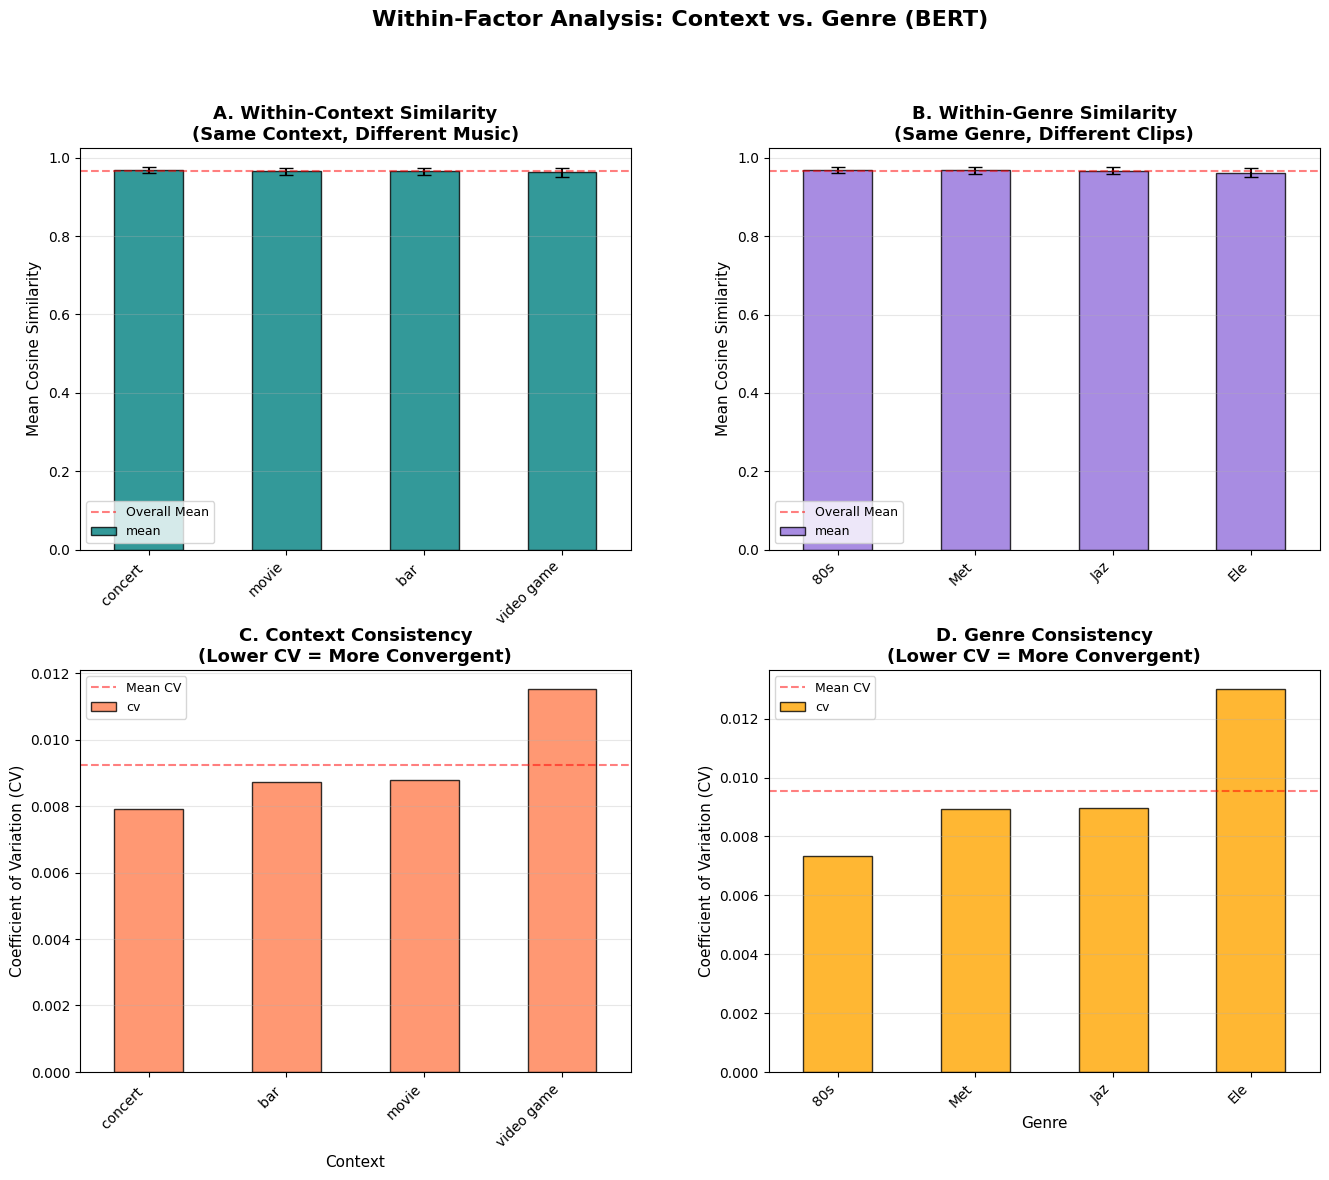

✓ Saved: BERT_within_factor_comparison.png

2. Generating pairwise comparison (Context vs. Genre)...


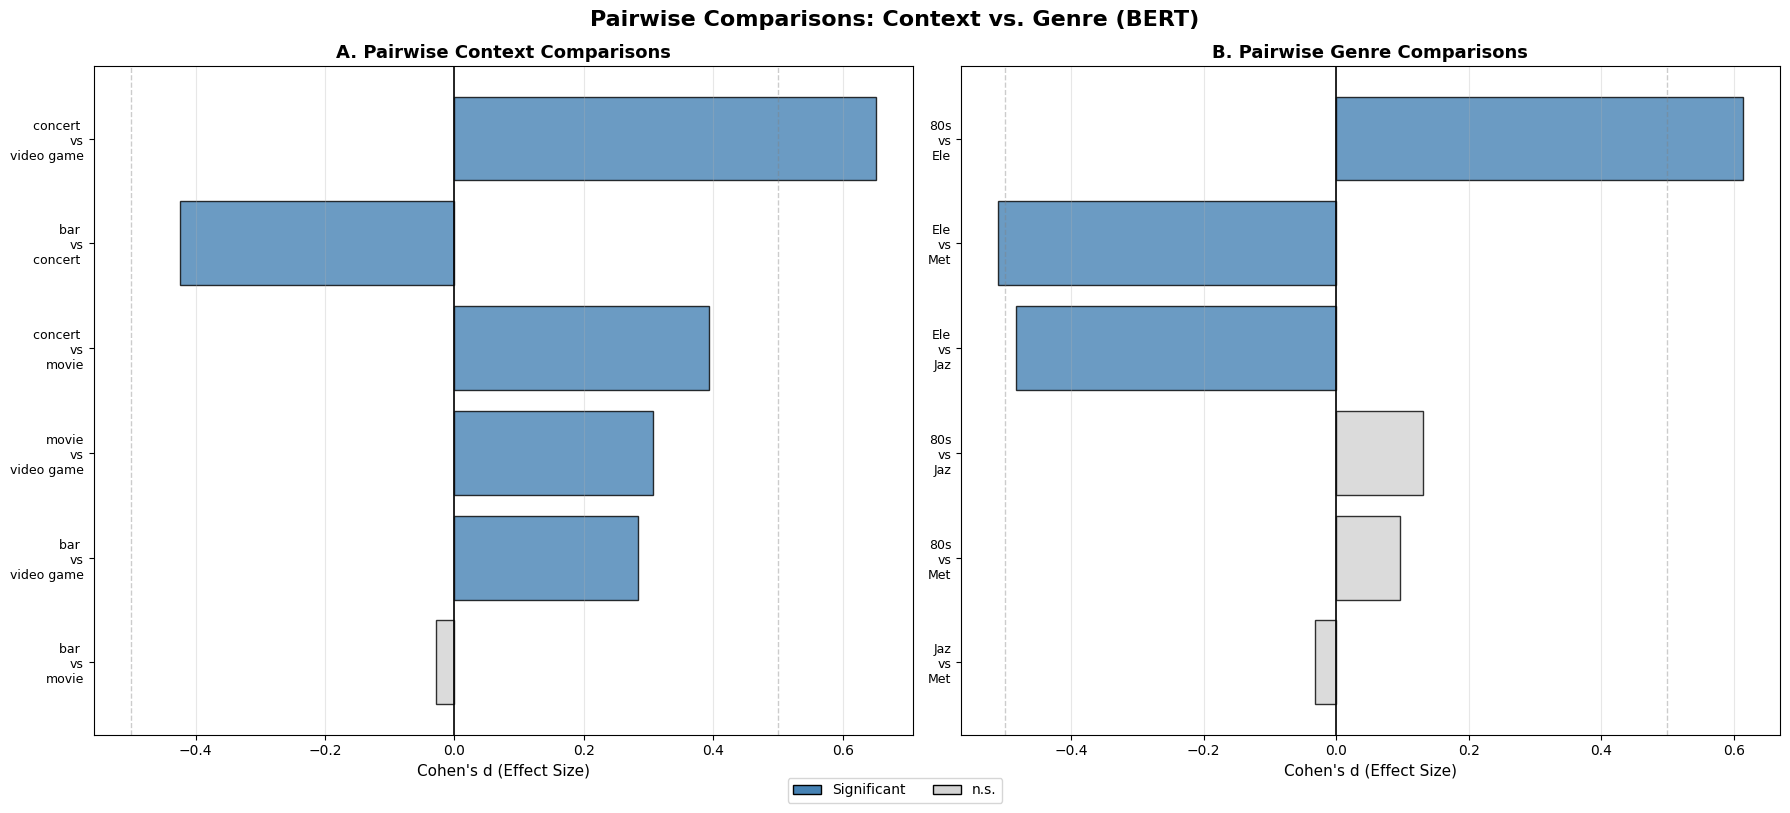

✓ Saved: BERT_pairwise_comparison.png

3. Generating music vs. context comparison (Context vs. Genre)...


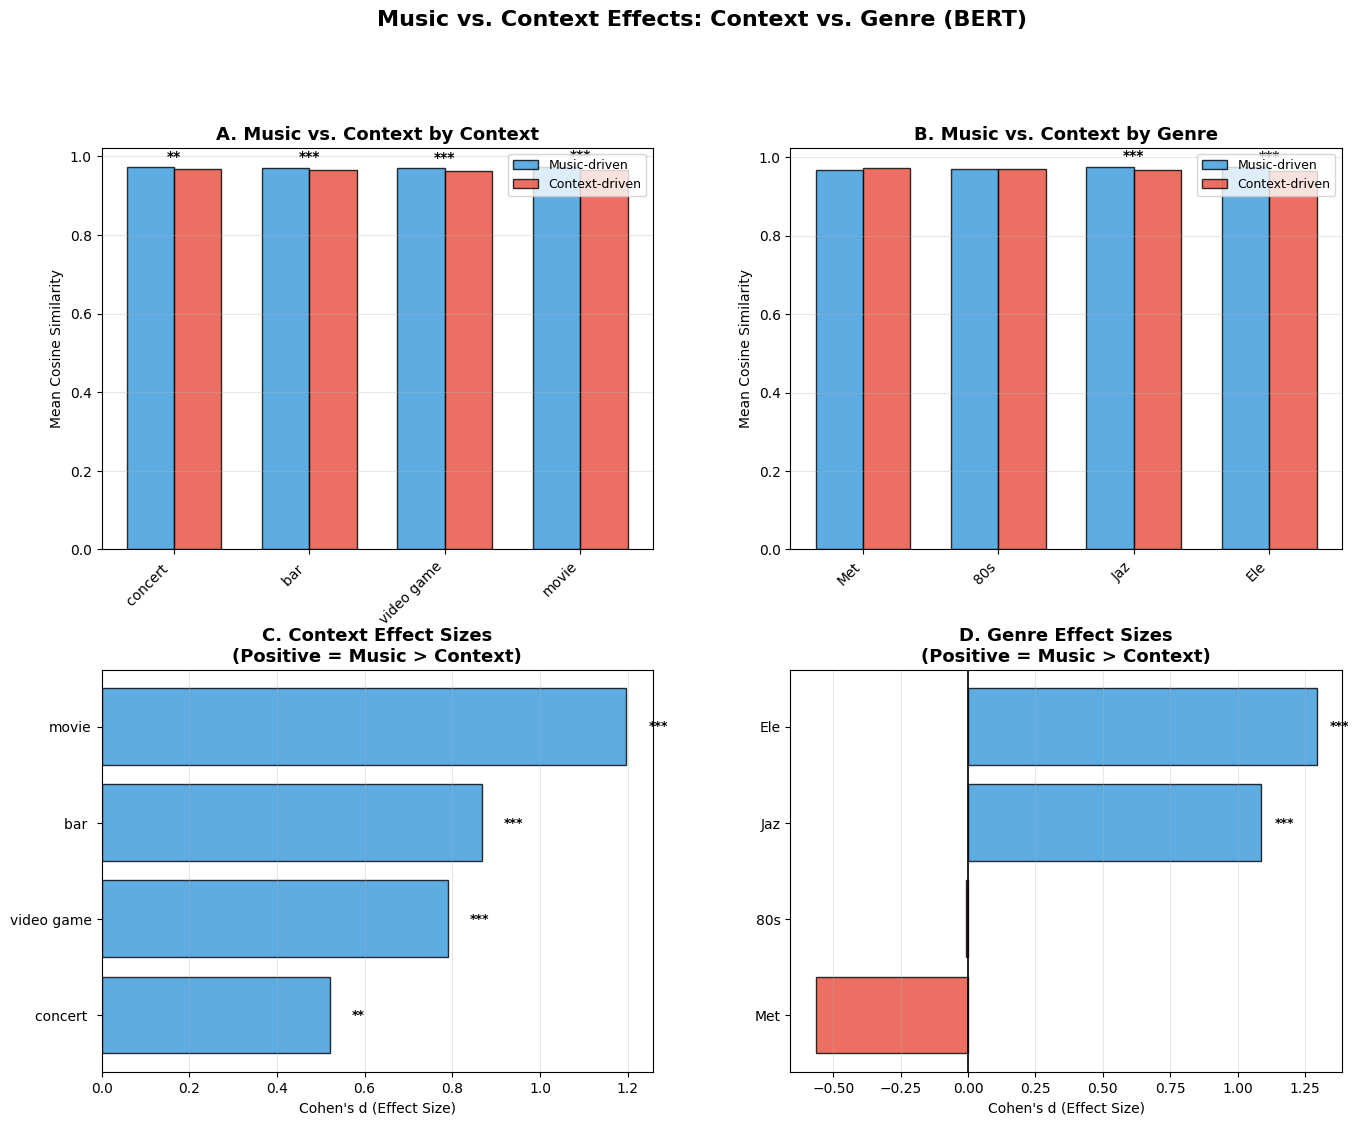

✓ Saved: BERT_music_vs_context_comparison.png

4. Generating consistency comparison (Context vs. Genre)...


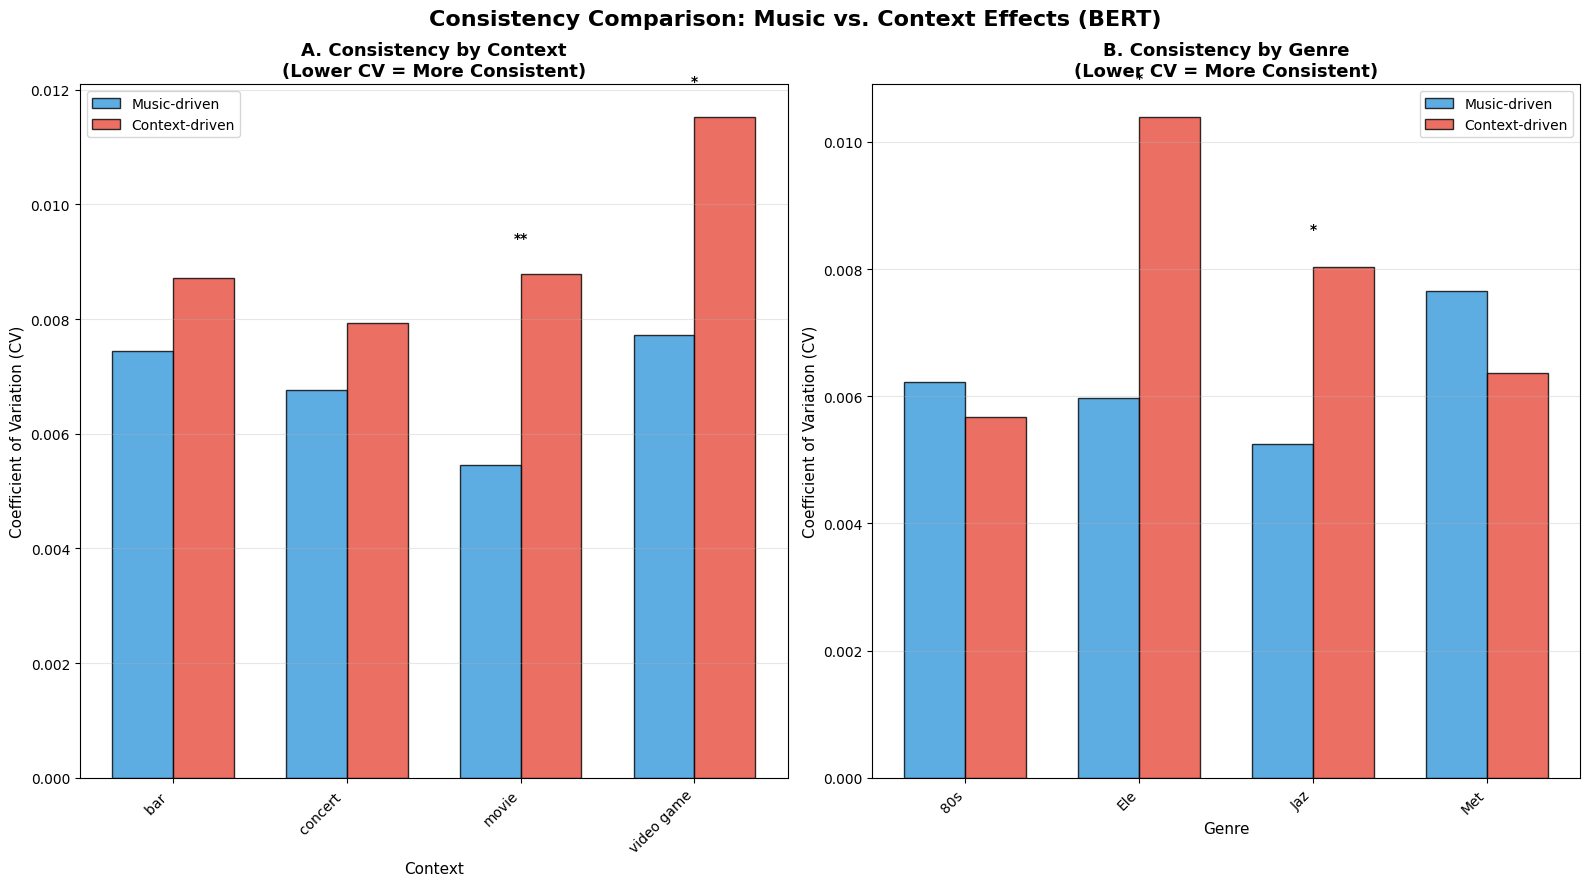

✓ Saved: BERT_consistency_comparison.png

5. Generating similarity matrices (Context vs. Genre)...


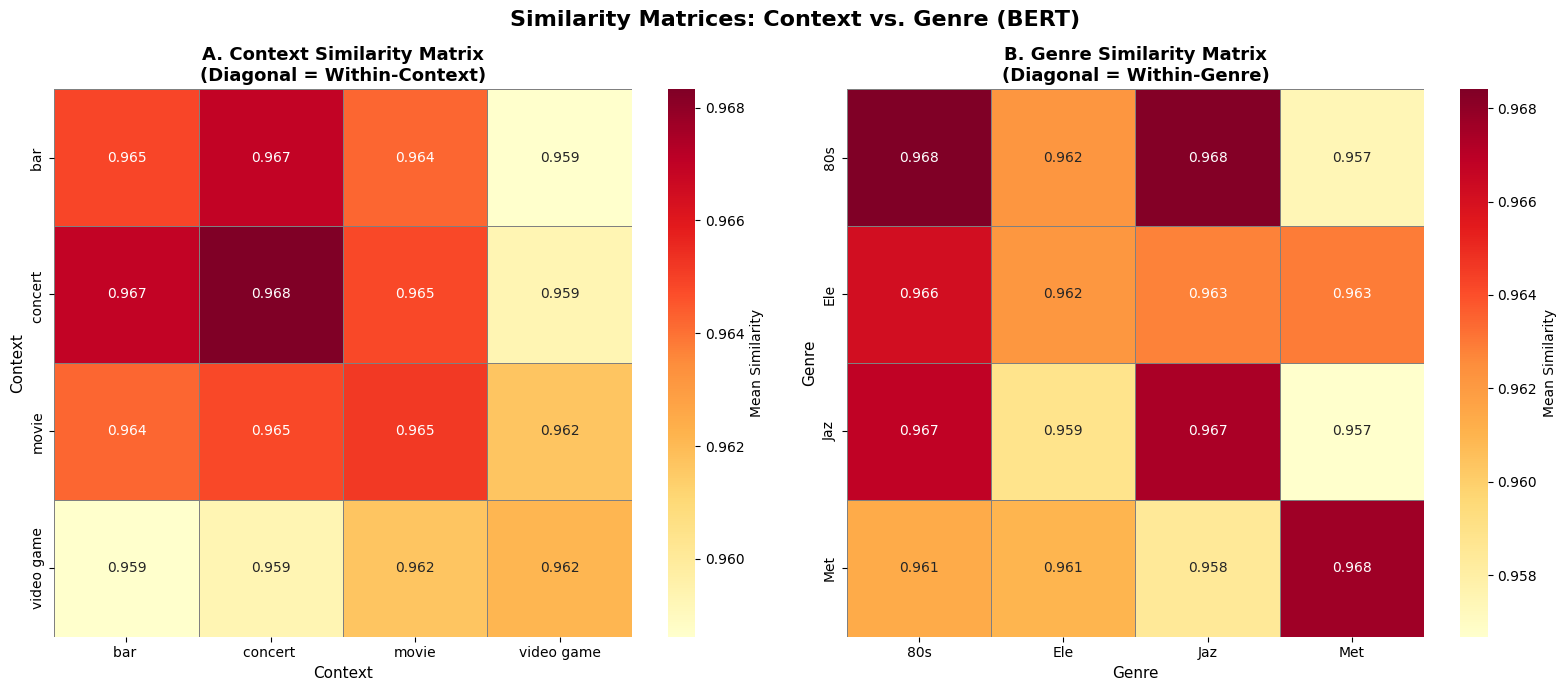

✓ Saved: BERT_similarity_matrices.png

6. Generating Genre × Context interaction heatmap...


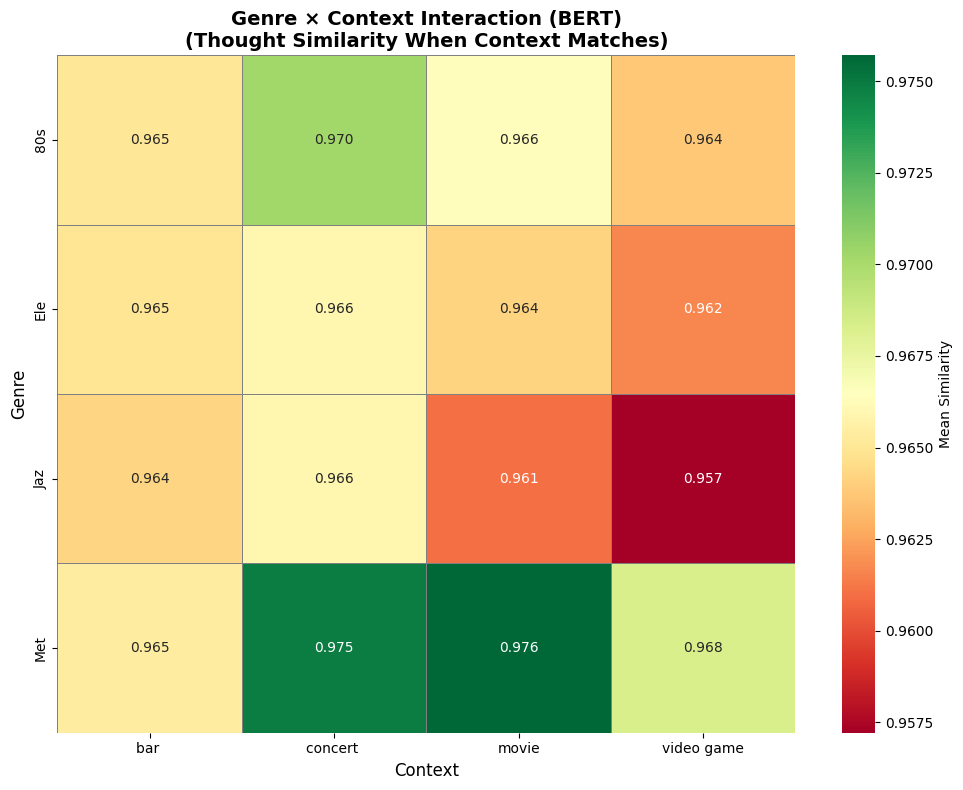

✓ Saved: BERT_genre_context_interaction.png

VISUALIZATION SUMMARY
Generated 6 comparative figures:
  Fig1: Within-factor comparison (2×2: similarity + consistency)
  Fig2: Pairwise comparison (1×2: effect sizes)
  Fig3: Music vs. context comparison (2×2: means + effect sizes)
  Fig4: Consistency comparison (1×2: music vs. context CVs)
  Fig5: Similarity matrices (1×2: context + genre heatmaps)
  Fig6: Genre × Context interaction (heatmap)

All context vs. genre comparisons are side-by-side for easy comparison!


In [12]:
# ---------------------------------------------------------------------------
def create_comparative_within_factor_figure(context_df, genre_df):
    """
    Side-by-side comparison of within-factor similarity and consistency.
    Layout (2x2): Context similarity, Genre similarity, Context CV, Genre CV
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    context_sorted = context_df.sort_values('mean', ascending=False)
    genre_sorted = genre_df.sort_values('mean', ascending=False)

    # PANEL A: Context within-factor similarity
    ax_a = fig.add_subplot(gs[0, 0])
    context_sorted.plot(kind='bar', x='context', y='mean', yerr='std',
                        ax=ax_a, capsize=5, color='teal',
                        edgecolor='black', alpha=0.8, legend=False)
    ax_a.set_title('A. Within-Context Similarity\n(Same Context, Different Music)',
                   fontsize=13, fontweight='bold')
    ax_a.set_xlabel('')
    ax_a.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_a.grid(axis='y', alpha=0.3)
    ax_a.axhline(y=context_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_a.legend(fontsize=9)

    # PANEL B: Genre within-factor similarity
    ax_b = fig.add_subplot(gs[0, 1])
    genre_sorted.plot(kind='bar', x='genre', y='mean', yerr='std',
                      ax=ax_b, capsize=5, color='mediumpurple',
                      edgecolor='black', alpha=0.8, legend=False)
    ax_b.set_title('B. Within-Genre Similarity\n(Same Genre, Different Clips)',
                   fontsize=13, fontweight='bold')
    ax_b.set_xlabel('')
    ax_b.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_b.grid(axis='y', alpha=0.3)
    ax_b.axhline(y=genre_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_b.legend(fontsize=9)

    # PANEL C: Context consistency (CV)
    ax_c = fig.add_subplot(gs[1, 0])
    context_cv_sorted = context_df.sort_values('cv')
    context_cv_sorted.plot(kind='bar', x='context', y='cv',
                           ax=ax_c, color='coral',
                           edgecolor='black', alpha=0.8, legend=False)
    ax_c.set_title('C. Context Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_c.set_xlabel('Context', fontsize=11)
    ax_c.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_c.set_xticklabels(context_cv_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_c.grid(axis='y', alpha=0.3)
    ax_c.axhline(y=context_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_c.legend(fontsize=9)

    # PANEL D: Genre consistency (CV)
    ax_d = fig.add_subplot(gs[1, 1])
    genre_cv_sorted = genre_df.sort_values('cv')
    genre_cv_sorted.plot(kind='bar', x='genre', y='cv',
                         ax=ax_d, color='orange',
                         edgecolor='black', alpha=0.8, legend=False)
    ax_d.set_title('D. Genre Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_d.set_xlabel('Genre', fontsize=11)
    ax_d.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_d.set_xticklabels(genre_cv_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_d.grid(axis='y', alpha=0.3)
    ax_d.axhline(y=genre_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_d.legend(fontsize=9)

    plt.suptitle('Within-Factor Analysis: Context vs. Genre (BERT)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_within_factor_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_within_factor_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df):
    """Side-by-side comparison of pairwise effect sizes."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # PANEL A: Context pairwise effect sizes
    if len(context_pairs_df) > 0:
        context_pairs_df['comparison'] = (context_pairs_df['context1'] + '\nvs\n' +
                                          context_pairs_df['context2'])
        context_sorted = context_pairs_df.sort_values('d', key=abs, ascending=True)
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in context_sorted['sig']]

        axes[0].barh(range(len(context_sorted)), context_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[0].set_yticks(range(len(context_sorted)))
        axes[0].set_yticklabels(context_sorted['comparison'], fontsize=9)
        axes[0].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[0].set_title('A. Pairwise Context Comparisons',
                         fontsize=13, fontweight='bold')
        axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].grid(axis='x', alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[0].transAxes)

    # PANEL B: Genre pairwise effect sizes
    if len(genre_pairs_df) > 0:
        genre_pairs_df['comparison'] = (genre_pairs_df['genre1'] + '\nvs\n' +
                                        genre_pairs_df['genre2'])
        genre_sorted = genre_pairs_df.sort_values('d', key=abs, ascending=True)
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in genre_sorted['sig']]

        axes[1].barh(range(len(genre_sorted)), genre_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[1].set_yticks(range(len(genre_sorted)))
        axes[1].set_yticklabels(genre_sorted['comparison'], fontsize=9)
        axes[1].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[1].set_title('B. Pairwise Genre Comparisons',
                         fontsize=13, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[1].transAxes)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label='Significant'),
        Patch(facecolor='lightgray', edgecolor='black', label='n.s.')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2,
              fontsize=10, bbox_to_anchor=(0.5, -0.02))

    plt.suptitle('Pairwise Comparisons: Context vs. Genre (BERT)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_pairwise_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_pairwise_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df):
    """Side-by-side comparison of music vs. context effects by factor."""
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    # PANEL A: Context music vs. context means
    ax_a = fig.add_subplot(gs[0, 0])
    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('difference')
        x = np.arange(len(context_sorted))
        width = 0.35

        ax_a.bar(x - width/2, context_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_a.bar(x + width/2, context_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_a.set_xlabel('')
        ax_a.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_a.set_title('A. Music vs. Context by Context',
                      fontsize=13, fontweight='bold')
        ax_a.set_xticks(x)
        ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        ax_a.legend(fontsize=9, loc='upper right')
        ax_a.grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_a.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')

    # PANEL B: Genre music vs. context means
    ax_b = fig.add_subplot(gs[0, 1])
    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('difference')
        x = np.arange(len(genre_sorted))
        width = 0.35

        ax_b.bar(x - width/2, genre_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_b.bar(x + width/2, genre_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_b.set_xlabel('')
        ax_b.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_b.set_title('B. Music vs. Context by Genre',
                      fontsize=13, fontweight='bold')
        ax_b.set_xticks(x)
        ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        ax_b.legend(fontsize=9, loc='upper right')
        ax_b.grid(axis='y', alpha=0.3)

        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_b.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')

    # PANEL C: Context effect sizes
    ax_c = fig.add_subplot(gs[1, 0])
    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('effect_size')
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in context_sorted['effect_size']]

        ax_c.barh(range(len(context_sorted)), context_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)
        ax_c.set_yticks(range(len(context_sorted)))
        ax_c.set_yticklabels(context_sorted['context'], fontsize=10)
        ax_c.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_c.set_title('C. Context Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_c.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_c.grid(axis='x', alpha=0.3)

        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_c.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')

    # PANEL D: Genre effect sizes
    ax_d = fig.add_subplot(gs[1, 1])
    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('effect_size')
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in genre_sorted['effect_size']]

        ax_d.barh(range(len(genre_sorted)), genre_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)
        ax_d.set_yticks(range(len(genre_sorted)))
        ax_d.set_yticklabels(genre_sorted['genre'], fontsize=10)
        ax_d.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_d.set_title('D. Genre Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_d.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_d.grid(axis='x', alpha=0.3)

        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_d.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')

    plt.suptitle('Music vs. Context Effects: Context vs. Genre (BERT)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_music_vs_context_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_music_vs_context_comparison.png")


# ---------------------------------------------------------------------------
def create_comparative_consistency_figure(context_consistency_comp_df, genre_consistency_comp_df):
    """Side-by-side comparison of music vs. context consistency."""
    # Increased figure height for better spacing
    fig, axes = plt.subplots(1, 2, figsize=(16, 9))

    # PANEL A: Context music vs. context consistency
    if len(context_consistency_comp_df) > 0:
        context_sorted = context_consistency_comp_df.sort_values('context')
        x = np.arange(len(context_sorted))
        width = 0.35

        bars1 = axes[0].bar(x - width/2, context_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        bars2 = axes[0].bar(x + width/2, context_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[0].set_xlabel('Context', fontsize=11)
        axes[0].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[0].set_title('A. Consistency by Context\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        axes[0].legend(fontsize=10)
        axes[0].grid(axis='y', alpha=0.3)

        # Adjusted vertical position for significance stars
        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(bars1[i].get_height(), bars2[i].get_height()) + 0.0005 # Adjusted y_pos
                axes[0].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')

    # PANEL B: Genre music vs. context consistency
    if len(genre_consistency_comp_df) > 0:
        genre_sorted = genre_consistency_comp_df.sort_values('genre')
        x = np.arange(len(genre_sorted))
        width = 0.35

        bars1 = axes[1].bar(x - width/2, genre_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        bars2 = axes[1].bar(x + width/2, genre_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[1].set_xlabel('Genre', fontsize=11)
        axes[1].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[1].set_title('B. Consistency by Genre\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)

        # Adjusted vertical position for significance stars
        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(bars1[i].get_height(), bars2[i].get_height()) + 0.0005 # Adjusted y_pos
                axes[1].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')


    plt.suptitle('Consistency Comparison: Music vs. Context Effects (BERT)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_consistency_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_consistency_comparison.png")


# ---------------------------------------------------------------------------
def create_similarity_matrices_figure(context_within_df, genre_within_df, sim_df, metadata):
    """Side-by-side similarity matrices for context and genre."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PANEL A: Context similarity matrix
    unique_contexts = metadata['context_word'].unique()
    context_matrix = np.zeros((len(unique_contexts), len(unique_contexts)))

    for i, ctx1 in enumerate(unique_contexts):
        for j, ctx2 in enumerate(unique_contexts):
            if i == j:
                val = context_within_df[context_within_df['context'] == ctx1]['mean'].values
                context_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                cross_sims = sim_df[
                    (sim_df['context_i'] == ctx1) &
                    (sim_df['context_j'] == ctx2)
                ]['similarity']

                if len(cross_sims) > 0:
                    context_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['context_i'] == ctx2) &
                        (sim_df['context_j'] == ctx1)
                    ]['similarity']
                    context_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(context_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_contexts, yticklabels=unique_contexts, ax=axes[0],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(context_matrix),
                linewidths=0.5, linecolor='gray')

    axes[0].set_title('A. Context Similarity Matrix\n(Diagonal = Within-Context)',
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Context', fontsize=11)
    axes[0].set_ylabel('Context', fontsize=11)

    # PANEL B: Genre similarity matrix
    unique_genres = metadata['genre_code'].unique()
    genre_matrix = np.zeros((len(unique_genres), len(unique_genres)))

    for i, genre1 in enumerate(unique_genres):
        for j, genre2 in enumerate(unique_genres):
            if i == j:
                val = genre_within_df[genre_within_df['genre'] == genre1]['mean'].values
                genre_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                cross_sims = sim_df[
                    (sim_df['genre_i'] == genre1) &
                    (sim_df['genre_j'] == genre2)
                ]['similarity']

                if len(cross_sims) > 0:
                    genre_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['genre_i'] == genre2) &
                        (sim_df['genre_j'] == genre1)
                    ]['similarity']
                    genre_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(genre_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_genres, yticklabels=unique_genres, ax=axes[1],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(genre_matrix),
                linewidths=0.5, linecolor='gray')

    axes[1].set_title('B. Genre Similarity Matrix\n(Diagonal = Within-Genre)',
                     fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Genre', fontsize=11)
    axes[1].set_ylabel('Genre', fontsize=11)

    plt.suptitle('Similarity Matrices: Context vs. Genre (BERT)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_similarity_matrices.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_similarity_matrices.png")


# ---------------------------------------------------------------------------
def create_genre_context_interaction_heatmap(genre_context_df):
    """Create Genre × Context interaction heatmap."""
    fig, ax = plt.subplots(figsize=(10, 8))

    genre_context_pivot = genre_context_df.pivot(index='genre', columns='context', values='mean')

    sns.heatmap(genre_context_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax, cbar_kws={'label': 'Mean Similarity'},
                linewidths=0.5, linecolor='gray')

    ax.set_title('Genre × Context Interaction (BERT)\n(Thought Similarity When Context Matches)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Context', fontsize=12)
    ax.set_ylabel('Genre', fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_genre_context_interaction.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: BERT_genre_context_interaction.png")


# ==============================================================================
# GENERATE ALL VISUALIZATIONS
# ==============================================================================
print("\n1. Generating within-factor comparison (Context vs. Genre)...")
create_comparative_within_factor_figure(within_context_df, within_genre_df)

print("\n2. Generating pairwise comparison (Context vs. Genre)...")
create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df)

print("\n3. Generating music vs. context comparison (Context vs. Genre)...")
create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df)

print("\n4. Generating consistency comparison (Context vs. Genre)...")
create_comparative_consistency_figure(context_consistency_comparison_df,
                                      genre_consistency_comparison_df)

print("\n5. Generating similarity matrices (Context vs. Genre)...")
create_similarity_matrices_figure(within_context_df, within_genre_df,
                                  sim_df_docs, METdocs)

print("\n6. Generating Genre × Context interaction heatmap...")
create_genre_context_interaction_heatmap(genre_context_df)


print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print("Generated 6 comparative figures:")
print("  Fig1: Within-factor comparison (2×2: similarity + consistency)")
print("  Fig2: Pairwise comparison (1×2: effect sizes)")
print("  Fig3: Music vs. context comparison (2×2: means + effect sizes)")
print("  Fig4: Consistency comparison (1×2: music vs. context CVs)")
print("  Fig5: Similarity matrices (1×2: context + genre heatmaps)")
print("  Fig6: Genre × Context interaction (heatmap)")
print("\nAll context vs. genre comparisons are side-by-side for easy comparison!")
print("="*70)

### Combined Condition Comparisons

In [13]:
print("\n\n" + "-"*70)
print("COMBINED CONDITION COMPARISONS")
print("-"*70)
print("Testing specific scenarios while controlling for other factors")


# ==============================================================================
# FUNCTION SET-UP
# ==============================================================================
def compare_conditions(df, cond1, cond2, label1, label2):
    """
    Compare two specific conditions with t-test and effect size.

    Parameters:
    -----------
    df : pd.DataFrame
        Similarity dataframe with 'condition' and 'similarity' columns
    cond1, cond2 : str
        Condition identifiers to compare
    label1, label2 : str
        Human-readable labels for output

    Returns:
    --------
    dict : Comparison statistics
    """
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    if len(data1) < 2 or len(data2) < 2:
        print(f"WARNING: Insufficient data for {label1} vs {label2}")
        return None

    t_stat, p_value = stats.ttest_ind(data1, data2)
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }


# 1. PRIMARY COMPARISON: Music vs Context Influence
print("\n1. PRIMARY COMPARISON: Music vs Context Influence (isolated effects)")
print("-" * 70)

music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']

music_mean = music_driven_docs.mean()
context_mean = context_driven_docs.mean()
music_std = music_driven_docs.std()
context_std = context_driven_docs.std()

# Calculate 95% CI
from scipy import stats as sp_stats
music_ci = sp_stats.t.interval(0.95, len(music_driven_docs)-1,
                                loc=music_mean,
                                scale=music_std/np.sqrt(len(music_driven_docs)))
context_ci = sp_stats.t.interval(0.95, len(context_driven_docs)-1,
                                  loc=context_mean,
                                  scale=context_std/np.sqrt(len(context_driven_docs)))

# Statistical comparison
primary_effect = compare_conditions(
    sim_df_docs,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Clip, Different Context',
    'Different Clip, Same Context'
)

print(f"\nSame clip, different context: M={primary_effect['mean1']:.4f}, SD={music_std:.4f} (N={primary_effect['n1']})")
print(f"  95% CI: [{music_ci[0]:.4f}, {music_ci[1]:.4f}]")
print(f"\nDifferent clip, same context: M={primary_effect['mean2']:.4f}, SD={context_std:.4f} (N={primary_effect['n2']})")
print(f"  95% CI: [{context_ci[0]:.4f}, {context_ci[1]:.4f}]")
print(f"\nDifference: {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)")
print(f"t({primary_effect['n1'] + primary_effect['n2'] - 2}) = {primary_effect['t']:.3f}, p = {primary_effect['p']:.4f} {primary_effect['sig']}")
print(f"Cohen's d = {primary_effect['d']:.3f}")

if primary_effect['mean1'] > primary_effect['mean2']:
    print("\n→ When isolated: MUSIC (clip) drives similarity MORE than CONTEXT")
    print(f"   Music-driven similarity is {(primary_effect['diff']/context_mean)*100:.1f}% higher")
else:
    print("\n→ When isolated: CONTEXT drives similarity MORE than MUSIC (clip)")
    print(f"   Context-driven similarity is {abs(primary_effect['diff']/music_mean)*100:.1f}% higher")


# 2. GENRE EFFECTS (when clip and context both differ)
print("\n\n2. GENRE EFFECTS: When both clip and context differ")
print("-" * 70)

genre_effect = compare_conditions(
    sim_df_docs,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Both Different, Same Genre',
    'Both Different, Different Genre'
)

print(f"\nSame genre (different clip & context): M={genre_effect['mean1']:.4f} (N={genre_effect['n1']})")
print(f"Different genre (different clip & context): M={genre_effect['mean2']:.4f} (N={genre_effect['n2']})")
print(f"\nDifference: {genre_effect['diff']:.4f}")
print(f"t = {genre_effect['t']:.3f}, p = {genre_effect['p']:.4f} {genre_effect['sig']}, d = {genre_effect['d']:.3f}")

if genre_effect['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even when clip and context differ")
else:
    print("\n→ Genre does NOT significantly affect similarity when other factors differ")


# ==============================================================================
# OMNIBUS TEST
# ==============================================================================
print("\n\n" + "-"*70)
print("OMNIBUS TEST: Overall Condition Differences")
print("-"*70)

conditions_list = sim_df_docs['condition'].unique()
groups = [sim_df_docs[sim_df_docs['condition'] == cond]['similarity'] for cond in conditions_list]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions_list)} conditions:")
print(f"F({len(conditions_list)-1}, {len(sim_df_docs)-len(conditions_list)}) = {f_stat:.3f}, p = {p_anova:.4e}")

# Calculate eta-squared (effect size for ANOVA)
ss_between = sum(len(g) * (g.mean() - sim_df_docs['similarity'].mean())**2 for g in groups)
ss_total = sum((sim_df_docs['similarity'] - sim_df_docs['similarity'].mean())**2)
eta_squared = ss_between / ss_total

print(f"η² = {eta_squared:.4f}")

if p_anova < 0.001:
    print("→ Conditions are HIGHLY significantly different overall (p < .001)")
elif p_anova < 0.01:
    print("→ Conditions are significantly different overall (p < .01)")
elif p_anova < 0.05:
    print("→ Conditions show significant differences (p < .05)")
else:
    print("→ No significant differences between conditions")



----------------------------------------------------------------------
COMBINED CONDITION COMPARISONS
----------------------------------------------------------------------
Testing specific scenarios while controlling for other factors

1. PRIMARY COMPARISON: Music vs Context Influence (isolated effects)
----------------------------------------------------------------------

Same clip, different context: M=0.9718, SD=0.0068 (N=96)
  95% CI: [0.9704, 0.9731]

Different clip, same context: M=0.9651, SD=0.0092 (N=480)
  95% CI: [0.9643, 0.9660]

Difference: 0.0066 (+0.7%)
t(574) = 6.666, p = 0.0000 ***
Cohen's d = 0.815

→ When isolated: MUSIC (clip) drives similarity MORE than CONTEXT
   Music-driven similarity is 0.7% higher


2. GENRE EFFECTS: When both clip and context differ
----------------------------------------------------------------------

Same genre (different clip & context): M=0.9658 (N=288)
Different genre (different clip & context): M=0.9610 (N=1152)

Difference: 0.0047


#### Visualizations


Generating condition comparison visualizations...


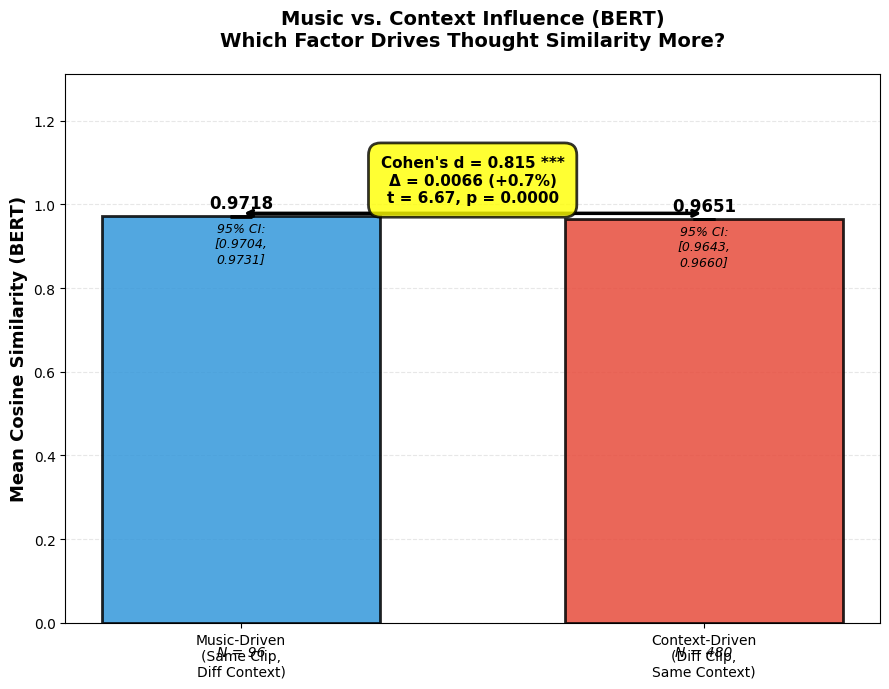

✓ Saved: BERT_COMP_music_vs_context.png


/tmp/ipython-input-36474393.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_c.set_xticklabels(labels_all, rotation=0, ha='center', fontsize=10)


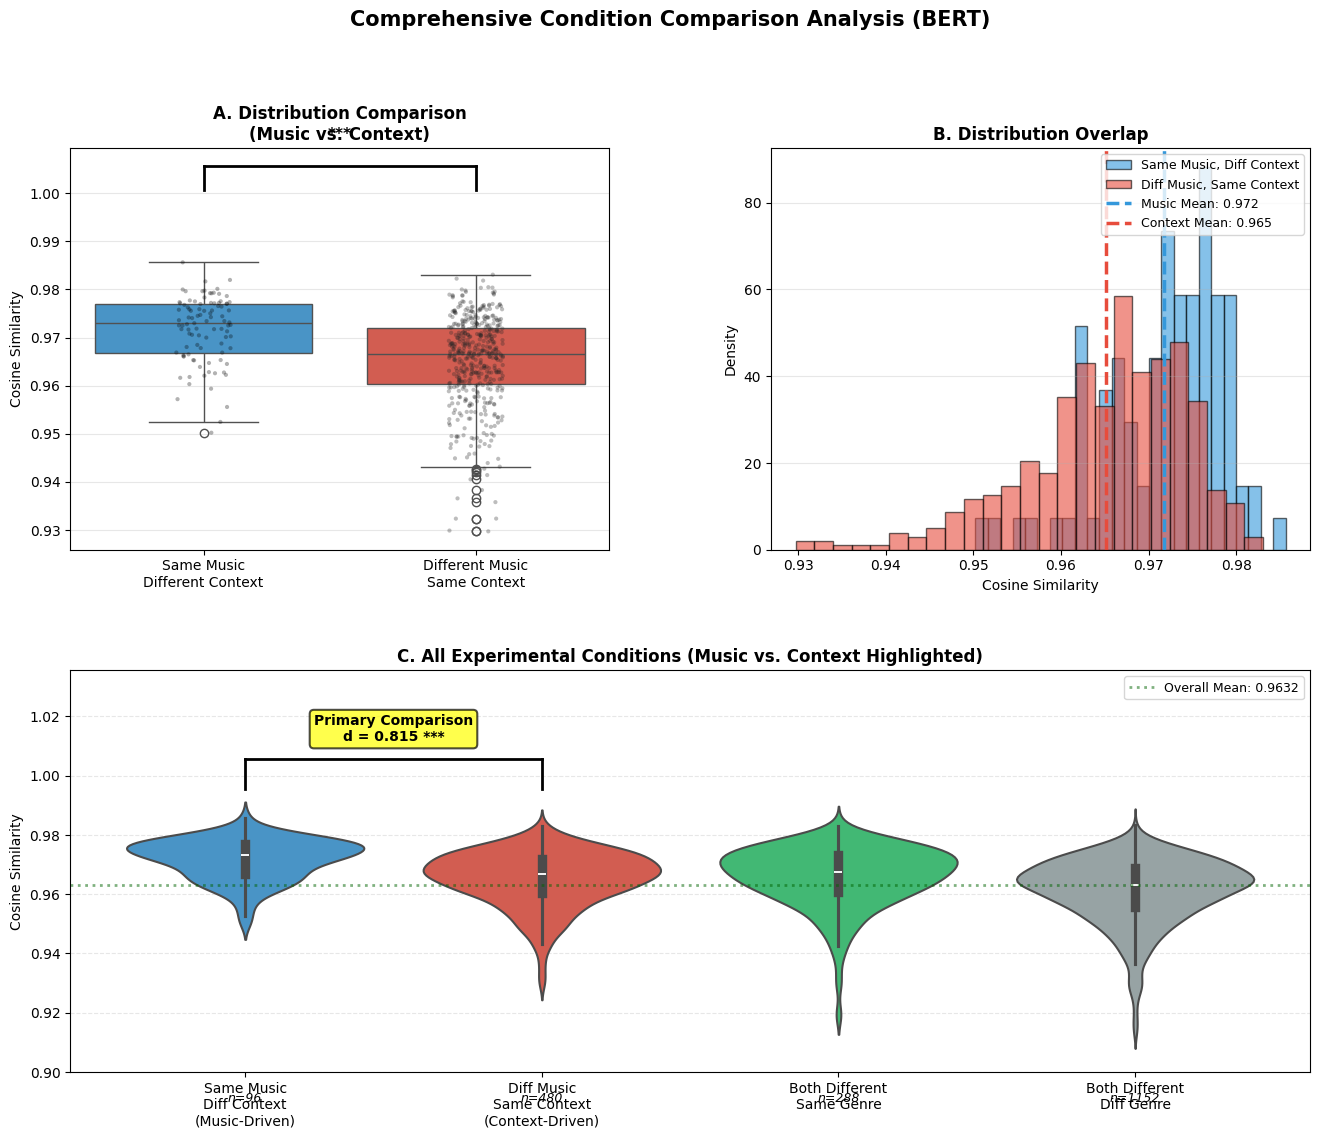

✓ Saved: BERT_comprehensive_conditions.png

✓ Saved: BERT_combined_comparisons_summary.csv


In [14]:
print("\nGenerating condition comparison visualizations...")


# ==============================================================================
# FIGURE 1: BAR CHART (Music vs Context with CI and Effect Size)
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 7))

categories = ['Music-Driven\n(Same Clip,\nDiff Context)',
              'Context-Driven\n(Diff Clip,\nSame Context)']
means = [music_mean, context_mean]
colors_primary = ['#3498db', '#e74c3c']

# Bar chart
bars = ax.bar(categories, means, color=colors_primary, edgecolor='black',
              linewidth=2, alpha=0.85, width=0.6)

# Error bars (95% CI)
ci_ranges = [
    (music_ci[1] - music_ci[0]) / 2,
    (context_ci[1] - context_ci[0]) / 2
]
ax.errorbar(range(len(means)), means, yerr=ci_ranges, fmt='none',
            ecolor='black', capsize=8, capthick=2, linewidth=2)

# Value labels
for i, (bar, mean, ci, ci_range) in enumerate(zip(bars, means, [music_ci, context_ci], ci_ranges)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + ci_range + 0.008,
            f'{mean:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., height - 0.015,
            f'95% CI:\n[{ci[0]:.4f},\n{ci[1]:.4f}]',
            ha='center', va='top', fontsize=9, style='italic')

# Effect size annotation
mid_point = (means[0] + means[1]) / 2
y_arrow = mid_point + 0.01
ax.annotate('', xy=(0, y_arrow), xytext=(1, y_arrow),
            arrowprops=dict(arrowstyle='<->', lw=2.5, color='black'))

effect_text = f"Cohen's d = {primary_effect['d']:.3f} {primary_effect['sig']}\n"
effect_text += f"Δ = {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)\n"
effect_text += f"t = {primary_effect['t']:.2f}, p = {primary_effect['p']:.4f}"
ax.text(0.5, y_arrow + 0.02, effect_text,
        ha='center', va='bottom', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow',
                 edgecolor='black', alpha=0.8, linewidth=2))

ax.set_ylabel('Mean Cosine Similarity (BERT)', fontsize=13, fontweight='bold')
ax.set_title('Music vs. Context Influence (BERT)\n' +
             'Which Factor Drives Thought Similarity More?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, max(means) * 1.35])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Sample sizes
ax.text(0, -0.08, f'N = {len(music_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')
ax.text(1, -0.08, f'N = {len(context_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_COMP_music_vs_context.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: BERT_COMP_music_vs_context.png")


# ==============================================================================
# FIGURE 2: COMPREHENSIVE 4-PANEL COMPARISON
# ==============================================================================
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# PANEL A: Boxplot comparison
ax_a = fig.add_subplot(gs[0, 0])
comparison_data = sim_df_docs[sim_df_docs['condition'].isin([
    'same_clip_diff_context',
    'diff_clip_same_context'
])].copy()

comparison_data['condition_label'] = comparison_data['condition'].map({
    'same_clip_diff_context': 'Same Music\nDifferent Context',
    'diff_clip_same_context': 'Different Music\nSame Context'
})

order = ['Same Music\nDifferent Context', 'Different Music\nSame Context']
palette = ['#e74c3c', '#3498db']

sns.boxplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
            hue='condition_label', palette=palette, legend=False, order=order)
sns.stripplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
              hue='condition_label', palette='dark:black', alpha=0.3, size=3,
              legend=False, order=order)

ax_a.set_title('A. Distribution Comparison\n(Music vs. Context)',
               fontsize=12, fontweight='bold')
ax_a.set_xlabel('')
ax_a.set_ylabel('Cosine Similarity', fontsize=10)
ax_a.grid(axis='y', alpha=0.3)

# Add significance bracket
y_max_a = comparison_data['similarity'].max()
bracket_y_a = y_max_a + 0.02
ax_a.plot([0, 1], [bracket_y_a, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([0, 0], [bracket_y_a - 0.005, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([1, 1], [bracket_y_a - 0.005, bracket_y_a], 'k-', linewidth=2)
ax_a.text(0.5, bracket_y_a + 0.005,
         primary_effect['sig'],
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# PANEL B: Distribution histogram
ax_b = fig.add_subplot(gs[0, 1])
ax_b.hist(music_driven_docs, bins=25, alpha=0.6, label='Same Music, Diff Context',
          color='#3498db', density=True, edgecolor='black')
ax_b.hist(context_driven_docs, bins=25, alpha=0.6, label='Diff Music, Same Context',
          color='#e74c3c', density=True, edgecolor='black')
ax_b.axvline(music_mean, color='#3498db', linestyle='--', linewidth=2.5,
             label=f'Music Mean: {music_mean:.3f}')
ax_b.axvline(context_mean, color='#e74c3c', linestyle='--', linewidth=2.5,
             label=f'Context Mean: {context_mean:.3f}')

ax_b.set_xlabel('Cosine Similarity', fontsize=10)
ax_b.set_ylabel('Density', fontsize=10)
ax_b.set_title('B. Distribution Overlap',
               fontsize=12, fontweight='bold')
ax_b.legend(fontsize=9, loc='upper right')
ax_b.grid(axis='y', alpha=0.3)

# PANEL C: All conditions violin plot
ax_c = fig.add_subplot(gs[1, :])

order_all = ['same_clip_diff_context', 'diff_clip_same_context',
             'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels_all = ['Same Music\nDiff Context\n(Music-Driven)',
              'Diff Music\nSame Context\n(Context-Driven)',
              'Both Different\nSame Genre',
              'Both Different\nDiff Genre']
palette_all = {
    'same_clip_diff_context': '#3498db',
    'diff_clip_same_context': '#e74c3c',
    'diff_clip_diff_context_same_genre': '#2ecc71',
    'diff_clip_diff_context_diff_genre': '#95a5a6'
}

sns.violinplot(data=sim_df_docs, x='condition', y='similarity', ax=ax_c,
               order=order_all, hue='condition', palette=palette_all,
               legend=False, inner='box', linewidth=1.5)

ax_c.set_xticklabels(labels_all, rotation=0, ha='center', fontsize=10)
ax_c.set_title('C. All Experimental Conditions (Music vs. Context Highlighted)',
               fontsize=12, fontweight='bold')
ax_c.set_xlabel('')
ax_c.set_ylabel('Cosine Similarity', fontsize=10)
ax_c.grid(axis='y', alpha=0.3, linestyle='--')
ax_c.set_axisbelow(True)

# Primary comparison bracket
y_max_c = sim_df_docs['similarity'].max()
bracket_y_c = y_max_c + 0.02
ax_c.plot([0, 1], [bracket_y_c, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([0, 0], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([1, 1], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.text(0.5, bracket_y_c + 0.005,
          f"Primary Comparison\nd = {primary_effect['d']:.3f} {primary_effect['sig']}",
          ha='center', va='bottom', fontsize=10, fontweight='bold',
          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7,
                   edgecolor='black', linewidth=1.5))

# Sample sizes
for i, cond in enumerate(order_all):
    n = len(sim_df_docs[sim_df_docs['condition'] == cond])
    ax_c.text(i, -0.05, f'n={n}', ha='center', va='top',
              transform=ax_c.get_xaxis_transform(), fontsize=9, style='italic')

# Overall mean line
overall_mean = sim_df_docs['similarity'].mean()
ax_c.axhline(y=overall_mean, color='darkgreen', linestyle=':',
             linewidth=2, alpha=0.5, label=f'Overall Mean: {overall_mean:.4f}')
ax_c.legend(loc='upper right', fontsize=9)
ax_c.set_ylim([0.9, sim_df_docs['similarity'].max() + 0.05])

plt.suptitle('Comprehensive Condition Comparison Analysis (BERT)',
            fontsize=15, fontweight='bold', y=0.995)
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/BERT_comprehensive_conditions.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: BERT_comprehensive_conditions.png")


# ==============================================================================
# SAVE SUMMARY TABLE
# ==============================================================================
summary_data = {
    'Comparison': [
        'Music vs. Context (Primary)',
        'Genre Effect (Both Differ)'
    ],
    'Condition 1': [
        'Same Clip, Diff Context',
        'Same Genre, Both Differ'
    ],
    'Mean 1': [
        f"{primary_effect['mean1']:.4f}",
        f"{genre_effect['mean1']:.4f}"
    ],
    'Condition 2': [
        'Diff Clip, Same Context',
        'Diff Genre, Both Differ'
    ],
    'Mean 2': [
        f"{primary_effect['mean2']:.4f}",
        f"{genre_effect['mean2']:.4f}"
    ],
    'Difference': [
        f"{primary_effect['diff']:.4f}",
        f"{genre_effect['diff']:.4f}"
    ],
    "Cohen's d": [
        f"{primary_effect['d']:.3f}",
        f"{genre_effect['d']:.3f}"
    ],
    'p-value': [
        f"{primary_effect['p']:.4f}",
        f"{genre_effect['p']:.4f}"
    ],
    'Sig.': [
        primary_effect['sig'],
        genre_effect['sig']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/BERT/BERT_combined_comparisons_summary.csv',
    index=False
)
print("\n✓ Saved: BERT_combined_comparisons_summary.csv")

### SUMMARY

In [15]:
print("\n\n" + "="*70)
print("=" * 70)
print("FINAL COMPREHENSIVE SUMMARY: BERT DOCUMENT-LEVEL ANALYSIS")
print("=" * 70)
print("="*70)
print(f"\nAnalysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Total METdocs Analyzed: {len(METdocs)}")
print(f"Total Pairwise Comparisons: {len(sim_df_docs)}")
print(f"Unique Clips: {METdocs['clip_name'].nunique()}")
print(f"Unique Contexts: {METdocs['context_word'].nunique()}")
print(f"Unique Genres: {METdocs['genre_code'].nunique()}")

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
print("-"*70)
if primary_effect['p'] < 0.05:
    if music_mean > context_mean:
        print(f"✓ MUSIC drives semantic similarity MORE than context")
        print(f"  • Aggregated thoughts are {(primary_effect['diff']/context_mean)*100:.1f}% more similar when")
        print(f"    listeners hear the same music in different contexts")
    else:
        print(f"✓ CONTEXT drives semantic similarity MORE than music")
        print(f"  • Aggregated thoughts are {abs(primary_effect['diff']/music_mean)*100:.1f}% more similar when")
        print(f"    listeners experience the same context with different music")
else:
    print(f"✗ Music and context have COMPARABLE influence")
    print(f"  • No significant difference detected (p = {primary_effect['p']:.4f})")

print("\n2. BINARY FACTOR EFFECTS")
print("-"*70)
binary_ranking = [
    ('CLIP', clip_comp['d'], clip_comp['sig']),
    ('CONTEXT', context_comp['d'], context_comp['sig']),
    ('GENRE', genre_comp['d'], genre_comp['sig'])
]
binary_ranking.sort(key=lambda x: abs(x[1]), reverse=True)
for i, (factor, d, sig) in enumerate(binary_ranking, 1):
    print(f"  {i}. {factor}: d = {d:+.3f} {sig}")

print("\n" + "="*70)
print("OUTPUT FILES GENERATED")
print("="*70)
print("\nCore Analysis:")
print("  • BERT_embeddings.npy")
print("  • BERT_cosineMatrix.csv")
print("  • BERT_similarity_by_condition.csv")
print("  • BERT_combined_comparisons_summary.csv")
print("\nContext-Specific:")
print("  • BERT_within_context_analysis.csv")
print("  • BERT_context_pairwise_comparisons.csv")
print("  • BERT_context_moderator_music_vs_context.csv")
print("  • BERT_context_consistency.csv")
print("\nGenre-Specific:")
print("  • BERT_within_genre_analysis.csv")
print("  • BERT_genre_pairwise_comparisons.csv")
print("  • BERT_genre_moderator_music_vs_context.csv")
print("  • BERT_genre_consistency.csv")
print("\nInteraction:")
print("  • BERT_genre_context_interaction.csv")
print("\nVisualizations:")
print("  • BERT_binary_comparisons.png")
print("  • BERT_COMP_music_vs_context.png")
print("  • BERT_comprehensive_conditions.png")
print("  • METdocs_heatmap_BERT.png")

print("\n" + "="*70)
print("COMPARISON WITH TF-IDF")
print("="*70)
print("\nThis BERT analysis uses IDENTICAL structure as TF-IDF:")
print("  ✓ Same condition categories")
print("  ✓ Same statistical comparisons")
print("  ✓ Same factor-specific analyses")
print("  ✓ Same visualization formats")
print("\nKey differences:")
print("  • BERT: Semantic similarity (contextual meaning)")
print("  • TF-IDF: Lexical similarity (word frequency)")
print("\nBoth analyses are directly comparable for:")
print("  • Effect sizes (Cohen's d)")
print("  • Statistical significance patterns")
print("  • Factor rankings")
print("  • Consistency measures")

print("\n" + "="*70)
print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("="*70)
print(f"\nCompleted: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nFor questions or issues, contact: Hazel A. van der Walle")
print("Durham University, Music Department")
print("GitHub: https://github.com/HazelvdW/context-framed-listening")
print("\n" + "="*70)



FINAL COMPREHENSIVE SUMMARY: BERT DOCUMENT-LEVEL ANALYSIS

Analysis Date: 2025-10-31 22:07
Total METdocs Analyzed: 64
Total Pairwise Comparisons: 2016
Unique Clips: 16
Unique Contexts: 4
Unique Genres: 4

KEY FINDINGS

1. PRIMARY RESEARCH QUESTION: Music vs Context
----------------------------------------------------------------------
✓ MUSIC drives semantic similarity MORE than context
  • Aggregated thoughts are 0.7% more similar when
    listeners hear the same music in different contexts

2. BINARY FACTOR EFFECTS
----------------------------------------------------------------------
  1. CLIP: d = +1.000 ***
  2. GENRE: d = +0.553 ***
  3. CONTEXT: d = +0.248 ***

OUTPUT FILES GENERATED

Core Analysis:
  • BERT_embeddings.npy
  • BERT_cosineMatrix.csv
  • BERT_similarity_by_condition.csv
  • BERT_combined_comparisons_summary.csv

Context-Specific:
  • BERT_within_context_analysis.csv
  • BERT_context_pairwise_comparisons.csv
  • BERT_context_moderator_music_vs_context.csv
  • BER

## t-SNE (METdoc level)

### SET-UP

In [16]:
import os
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from collections import Counter



# ---------- PARAMETERS ----------
SVD_COMPONENTS = 50        # reduce BERT dimensionality before t-SNE (speeds up & denoises)
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
TSNE_RANDOM_STATE = 42

ANNOTATE_POINTS = False    # set True to label points with clip_name (can be crowded for many docs)
ANNOTATE_TOP = 20          # if annotating, annotate the top-N central / interesting points (by degree or freq)
PLOTLY_INTERACTIVE = True  # set True to save an interactive HTML (requires plotly)

# Word-level options (using BERT token embeddings, not Word2Vec)
DO_WORD_TSNE = True        # set False to skip words
TOP_N_WORDS = 300          # number of most frequent wordpieces to include in token t-SNE
ANNOTATE_K = 80            # how many tokens to annotate on the wordplot

# Paths: BERT outputs folder in repo
SAVE_DIR = '/content/context-framed-listening/NLP_outputs/BERT'
os.makedirs(SAVE_DIR, exist_ok=True)


# ---------- LOAD / PREP DATA ----------
# 1) METdocs: prefer existing METdocs variable in notebook; otherwise load saved CSV used earlier
text_column = 'METdescr_prepLVL1'

try:
    METdocs
    print("Using METdocs dataframe from notebook.")
except NameError:
    metdocs_csv = '/content/context-framed-listening/NLP_outputs/METdocsLVL1.csv'
    print(f"Loading METdocs from {metdocs_csv} ...")
    METdocs = pd.read_csv(metdocs_csv)
    print("Loaded METdocs.")

# Ensure required columns present
for col in ['ClipContext_pair', 'clip_name', 'context_word', 'genre_code', text_column]:
    if col not in METdocs.columns:
        raise KeyError(f"METdocs missing required column: {col}")

meta = METdocs[['ClipContext_pair', 'clip_name', 'context_word', 'genre_code']].reset_index(drop=True)

# 2) Document embeddings (BERT aggregated embeddings)
try:
    bert_embeddings
    X_docs = np.asarray(bert_embeddings)
    print("Using bert_embeddings from notebook.")
except NameError:
    emb_path = '/content/context-framed-listening/NLP_outputs/BERT/BERT_embeddings.npy'
    if os.path.exists(emb_path):
        print(f"Loading BERT document embeddings from {emb_path} ...")
        X_docs = np.load(emb_path)
    else:
        raise FileNotFoundError("bert_embeddings not found in notebook and BERT_embeddings.npy missing. Run the BERT embedding cell first.")

print(f"Document embeddings shape: {X_docs.shape}")
if X_docs.shape[0] != len(meta):
    raise ValueError(f"Number of embedding rows ({X_docs.shape[0]}) != number of METdocs ({len(meta)})")

# 3) BERT tokenizer / model for wordpiece-level t-SNE (optional)
# This code expects BERTtokeniser and BERTmodel to already be initialised in the notebook.
# If not, uncomment the following lines to load them (may download model).
# from transformers import BertTokenizer, BertModel
# BERTtokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
# BERTmodel = BertModel.from_pretrained('bert-base-uncased')

model_available = True
try:
    BERTtokeniser
    BERTmodel
except NameError:
    print("BERTtokeniser or BERTmodel not found in notebook: disabling wordpiece-level t-SNE.")
    model_available = False
    DO_WORD_TSNE = False



Using METdocs dataframe from notebook.
Using bert_embeddings from notebook.
Document embeddings shape: (64, 768)


### DIMENSIONALITY REDUCTION (TruncatedSVD)

In [17]:
# ---------- DIMENSIONALITY REDUCTION (PCA / TruncatedSVD) ----------
orig_dim = X_docs.shape[1]
n_svd = min(SVD_COMPONENTS, orig_dim - 1) if orig_dim > 1 else 1
if n_svd <= 0:
    n_svd = 1

print(f"Reducing document vectors from {orig_dim} -> {n_svd} components via PCA")
# PCA is appropriate for dense BERT vectors
pca = PCA(n_components=n_svd, random_state=TSNE_RANDOM_STATE)
X_svd = pca.fit_transform(X_docs)
explained = np.sum(pca.explained_variance_ratio_) if hasattr(pca, 'explained_variance_ratio_') else None
if explained is not None:
    print(f"Explained variance ratio (sum): {explained:.3f}")


Reducing document vectors from 768 -> 50 components via PCA
Explained variance ratio (sum): 0.963


### t-SNE (documents)

In [18]:
# ---------- t-SNE (documents) ----------
print("Running t-SNE on BERT document vectors...")
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER,
            random_state=TSNE_RANDOM_STATE, init='pca', learning_rate='auto')
X_doc_emb = tsne.fit_transform(X_svd)

emb_df = pd.DataFrame(X_doc_emb, columns=['TSNE1', 'TSNE2'])
emb_df = pd.concat([meta.reset_index(drop=True), emb_df], axis=1)

# Save coordinates
emb_csv = os.path.join(SAVE_DIR, 'METdocs_tsne_coords_BERT.csv')
emb_df.to_csv(emb_csv, index=False)
print(f"Saved document t-SNE coordinates to: {emb_csv}")


Running t-SNE on BERT document vectors...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved document t-SNE coordinates to: /content/context-framed-listening/NLP_outputs/BERT/METdocs_tsne_coords_BERT.csv


### Visualize

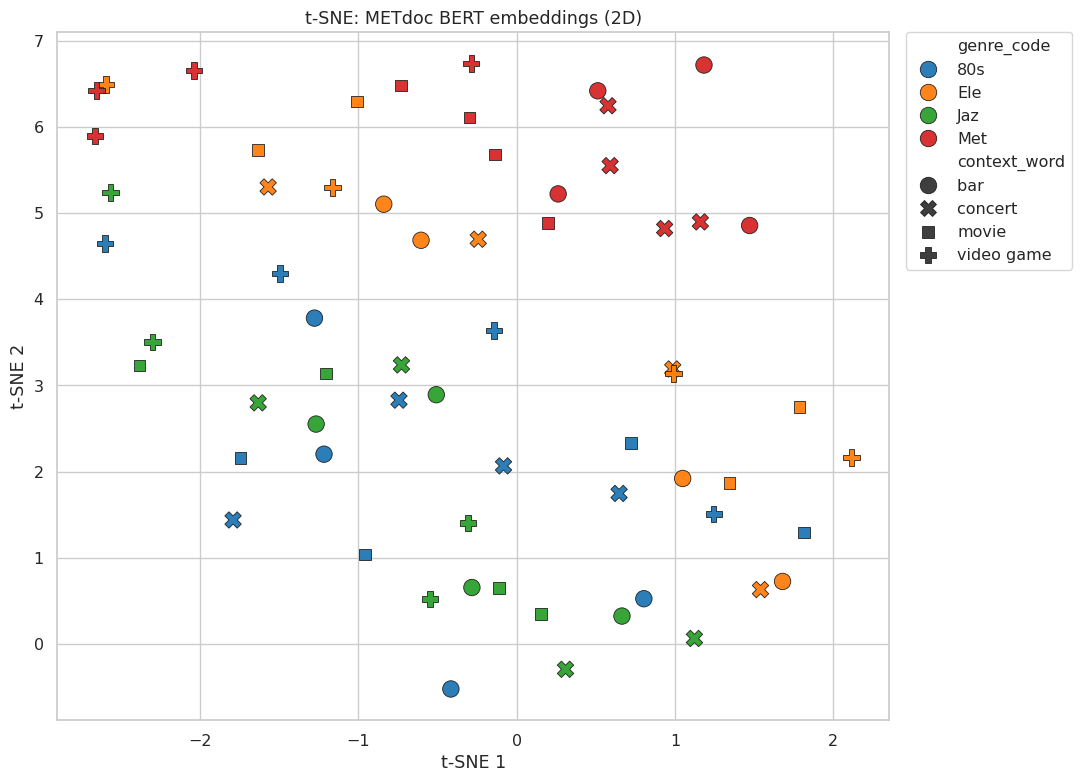

Saved document t-SNE plot to: /content/context-framed-listening/NLP_outputs/BERT/METdocs_tsne_plot_BERT.png
Saved interactive t-SNE plot to: /content/context-framed-listening/NLP_outputs/BERT/METdocs_tsne_plot_BERT_interactive.html


In [19]:
# ---------- PLOT (documents) ----------
plt.figure(figsize=(11, 8))
sns.set(style='whitegrid', font_scale=1.05)

# Use hue by genre, marker style by context_word (if many contexts, seaborn will cycle markers)
ax = sns.scatterplot(data=emb_df, x='TSNE1', y='TSNE2',
                     hue='genre_code', style='context_word',
                     palette='tab10', s=140, alpha=0.95, edgecolor='k', linewidth=0.6)

plt.title('t-SNE: METdoc BERT embeddings (2D)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Position legend outside
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=True)

plt.tight_layout()
png_path = os.path.join(SAVE_DIR, 'METdocs_tsne_plot_BERT.png')
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved document t-SNE plot to: {png_path}")

# Optional: annotate a few points (clip labels). Use with care for clutter.
if ANNOTATE_POINTS:
    # choose points to annotate: either all or a heuristic (here annotate the first ANNOTATE_TOP unique clips)
    annotate_n = min(ANNOTATE_TOP, len(emb_df))
    subset = emb_df.head(annotate_n)
    plt.figure(figsize=(11, 8))
    sns.scatterplot(data=emb_df, x='TSNE1', y='TSNE2', hue='genre_code', style='context_word',
                    palette='tab10', s=100, alpha=0.7)
    for _, row in subset.iterrows():
        plt.text(row['TSNE1'] + 1e-3, row['TSNE2'] + 1e-3, row['clip_name'], fontsize=9)
    plt.title('t-SNE (annotated subset)')
    plt.tight_layout()
    annotated_png = os.path.join(SAVE_DIR, 'METdocs_tsne_plot_BERT_annotated.png')
    plt.savefig(annotated_png, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved annotated t-SNE plot to: {annotated_png}")

# Optional: save interactive plot (plotly)
if PLOTLY_INTERACTIVE:
    try:
        import plotly.express as px
        html_path = os.path.join(SAVE_DIR, 'METdocs_tsne_plot_BERT_interactive.html')
        fig = px.scatter(emb_df, x='TSNE1', y='TSNE2',
                         color='genre_code', symbol='context_word',
                         hover_data=['ClipContext_pair', 'clip_name', 'context_word', 'genre_code'])
        fig.update_layout(title='t-SNE: METdoc BERT embeddings (interactive)')
        fig.write_html(html_path)
        print(f"Saved interactive t-SNE plot to: {html_path}")
    except Exception as e:
        print("Plotly not available or failed to create interactive plot:", e)


### t-SNE for WORDS (term vectors)

Preparing token-level t-SNE using BERT's input embeddings (wordpieces)...
Selected 300 top wordpieces from METdocs (requested TOP_N_WORDS=300).


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Saved token t-SNE coords to: /content/context-framed-listening/NLP_outputs/BERT/wordpiece_tsne_top300_BERT.csv


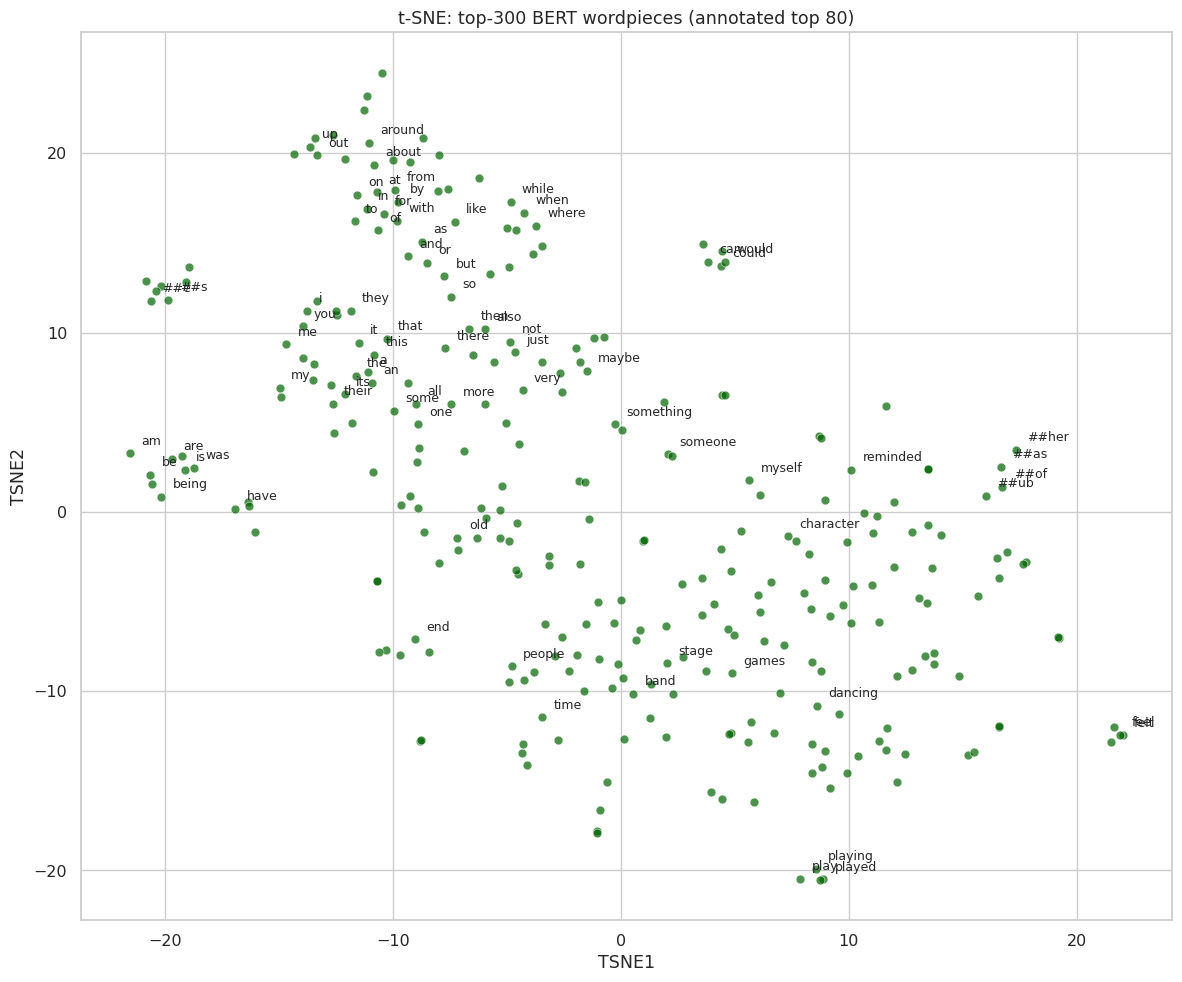

Saved token t-SNE plot to: /content/context-framed-listening/NLP_outputs/BERT/wordpiece_tsne_top300_BERT.png


In [20]:
# ---------- OPTIONAL: t-SNE for WORDPIECE TOKENS (using BERT input embeddings) ----------
if DO_WORD_TSNE and model_available:
    print("Preparing token-level t-SNE using BERT's input embeddings (wordpieces)...")

    # Tokenize all METdoc text using BERT tokenizer and count frequency of wordpieces
    all_tokens = []
    for text in METdocs[text_column].astype(str):
        toks = BERTtokeniser.tokenize(text)
        all_tokens.extend(toks)

    freq = Counter(all_tokens)
    filtered_terms = [w for w, _ in freq.most_common() if any(c.isalpha() for c in w)]
    # Keep only tokens that exist in tokenizer vocab (they will)
    top_terms = filtered_terms[:TOP_N_WORDS]
    print(f"Selected {len(top_terms)} top wordpieces from METdocs (requested TOP_N_WORDS={TOP_N_WORDS}).")

    if len(top_terms) == 0:
        print("No top terms found; skipping token-level t-SNE.")
    else:
        # Map token -> id and fetch BERT embedding weights for those ids
        vocab = BERTtokeniser.get_vocab()
        # Convert tokens to ids (if a token is not present use tokenizer.convert_tokens_to_ids)
        token_ids = [vocab.get(t, BERTtokeniser.convert_tokens_to_ids(t)) for t in top_terms]

        # Get embedding matrix from BERT model
        bert_word_emb = BERTmodel.embeddings.word_embeddings.weight.detach().cpu().numpy()

        # Build matrix of wordpiece vectors (rows = tokens)
        W = np.vstack([bert_word_emb[tid] for tid in token_ids])

        # Pre-reduce dimensionality if appropriate
        svd_w_components = min(30, W.shape[1] - 1) if W.shape[1] > 1 else 1
        if svd_w_components <= 0:
            svd_w_components = 1
        svd_w = TruncatedSVD(n_components=svd_w_components, random_state=TSNE_RANDOM_STATE)
        W_reduced = svd_w.fit_transform(W)

        # t-SNE on tokens
        tsne_w = TSNE(n_components=2, perplexity=min(30, max(5, TOP_N_WORDS//10)),
                      n_iter=TSNE_N_ITER, random_state=TSNE_RANDOM_STATE, init='pca', learning_rate='auto')
        W_emb = tsne_w.fit_transform(W_reduced)

        words_df = pd.DataFrame(W_emb, columns=['TSNE1', 'TSNE2'])
        words_df['term'] = top_terms
        words_csv = os.path.join(SAVE_DIR, f'wordpiece_tsne_top{len(top_terms)}_BERT.csv')
        words_df.to_csv(words_csv, index=False)
        print(f"Saved token t-SNE coords to: {words_csv}")

        # Plot tokens; annotate a subset (most frequent)
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=words_df, x='TSNE1', y='TSNE2', s=40, color='darkgreen', alpha=0.7)
        annotate_terms = [w for w, _ in freq.most_common() if w in top_terms][:ANNOTATE_K]
        for _, row in words_df[words_df['term'].isin(annotate_terms)].iterrows():
            plt.text(row['TSNE1'] + 0.5, row['TSNE2'] + 0.5, row['term'], fontsize=9)
        plt.title(f't-SNE: top-{len(top_terms)} BERT wordpieces (annotated top {len(annotate_terms)})')
        plt.tight_layout()
        words_png = os.path.join(SAVE_DIR, f'wordpiece_tsne_top{len(top_terms)}_BERT.png')
        plt.savefig(words_png, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved token t-SNE plot to: {words_png}")


In [21]:
# ---------- FINISHED ----------
print("t-SNE (BERT) complete. Adjust SVD_COMPONENTS / TSNE_PERPLEXITY / TSNE_N_ITER as needed.")

t-SNE (BERT) complete. Adjust SVD_COMPONENTS / TSNE_PERPLEXITY / TSNE_N_ITER as needed.


# ----

### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. BASELINE COMPARISON: Total shared features
6. OMNIBUS TEST: Overall condition differences
7. Effect Size Ranking

In [ ]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ At METdocs level: MUSIC drives similarity MORE than context")
else:
    print("\n→ At METdocs level: CONTEXT drives similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence at document level")
else:
    print("\n→ Genre does NOT significantly affect document-level similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_same_context',
    'diff_clip_same_context',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_same_context',
    'same_clip_diff_context',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 5. OMNIBUS TEST
# ----------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall? (METdocs level)")
print("-" * 70)

conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different at document level")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")

# 6. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------
print("\n\n6. CONDITION MEANS RANKING (METdocs level)")
print("-" * 70)

condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_statistical_comparisons_BERT.csv',
                      index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])


### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualization
7. Heatmap showing mean similarities between conditions

In [ ]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'same_clip_diff_context']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diff_clip_same_context']['similarity']
same_both = sim_df[sim_df['condition'] == 'same_clip_same_context']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_same_genre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_diff_genre']['similarity']

# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['same_clip_diff_context', 'diff_clip_same_context'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.3, size=4)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_01_music_vs_context_boxplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions: All Conditions (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_02_all_conditions_violin_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition: METdocs Level (95% CI)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_03_condition_means_barplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=20, alpha=0.5, label='Same Music, Diff Context',
        color='#3498db', density=True)
ax.hist(context_driven, bins=20, alpha=0.5, label='Diff Music, Same Context',
        color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_04_music_vs_context_histogram_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'same_clip_same_context',
    'same_clip_diff_context',
    'diff_clip_same_context',
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]

order = ['same_clip_same_context', 'same_clip_diff_context', 'diff_clip_same_context',
         'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: METdocs Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_05_hierarchical_comparison_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre effect when everything else differs
genre_comparison = sim_df[sim_df['condition'].isin([
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect: METdocs Level\n(Different Clip & Context)',
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (BERT)', fontsize=11)
axes[0].set_xlabel('')

# Show all conditions side by side
all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions\n(METdocs Level)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (BERT)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_06_genre_effects_summary_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition: METdocs Level', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_07_condition_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [ ]:
print("\n" + "-"*70)
print("METDOCS-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("  Data files:")
print("    - METdocs_embeddings_BERT.npy")
print("    - METdocs_cosineMatrix_BERT.csv")
print("    - METdocs_similarity_by_condition_BERT.csv")
print("    - METdocs_statistical_comparisons_BERT.csv")

print("\n  Visualisations:")
print("    - METdocs_heatmap_BERT.png")
print("    - METdocs_01_music_vs_context_boxplot_BERT.png")
print("    - METdocs_02_all_conditions_violin_BERT.png")
print("    - METdocs_03_condition_means_barplot_BERT.png")
print("    - METdocs_04_music_vs_context_histogram_BERT.png")
print("    - METdocs_05_hierarchical_comparison_BERT.png")
print("    - METdocs_06_genre_effects_summary_BERT.png")
print("    - METdocs_07_condition_heatmap_BERT.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY (METdocs Level)")
print("-"*70)

# Get the primary comparison again for summary
music_driven_summary = sim_df[sim_df['condition'] == 'same_clip_diff_context']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diff_clip_same_context']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context (METdocs level)")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

# Genre effects
same_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_same_genre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_diff_genre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS (METdocs level)")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

# Baseline
if len(same_both) > 0:
    print(f"\n3. BASELINE (identical clip-context pairs)")
    print(f"   → Note: Same clip + same context = same document (N={len(same_both)})")
    print(f"   → Mean similarity: {same_both.mean():.4f}")

print("\n" + "-"*70)
print("COMPARISON NOTE:")
print("-"*70)
print("This METdocs analysis uses IDENTICAL condition categories as the")
print("individual thought-level analysis, enabling direct comparison of:")
print("  - Effect sizes (Cohen's d)")
print("  - Condition rankings")
print("  - Statistical significance patterns")
print("\nKey differences:")
print("  - METdocs: N documents = ~64 (clip-context pairs)")
print("  - Individual: N pairs = ~1.9 million (all thought pairs)")
print("  - METdocs: Shows condition-level semantic profiles")
print("  - Individual: Shows individual-level variability and patterns")
print("\nUse both analyses together to understand patterns at different scales")
print("~"*70)

---
## ANALYSIS AT INDIVIDUAL MET LEVEL

Measuring semantic similarity between indivudal thought descriptions.

Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [ ]:
print("Loading preprocessed MET data...")
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

# Use the BERT-appropriate preprocessing column (minimal filtering)
thought_column = 'METdescr_prepLVL1'

print(f"Total individual MET descriptions for analysis: {len(dataMETpre)}")
print(f"Unique clips: {dataMETpre['clip_name'].nunique()}")
print(f"Unique contexts: {dataMETpre['context_word'].nunique()}")
print(f"Unique clip-context pairs: {dataMETpre['clip_context_PAIR'].nunique()}")


### BERT embeddings

Compute BERT embeddings for all individual thoughts:

In [ ]:
print("\nComputing BERT embeddings for individual thoughts...")
print("This may take several minutes for ~2000 thoughts...")

embeddings = []
for idx, row in dataMETpre.iterrows():
    text = str(row[thought_column])
    embedding = get_bert_embedding(text)
    embeddings.append(embedding)

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1}/{len(dataMETpre)} thoughts...")

embeddings = np.array(embeddings)
print(f"\nBERT embeddings shape: {embeddings.shape}")

# Save embeddings for reuse
np.save('/content/context-framed-listening/NLP_outputs/BERT/indvMET_embeddings_BERT.npy',
        embeddings)
print("Embeddings saved")

### Pairwise Cosine Similarity

In [ ]:
print("\nCalculating pairwise cosine similarity matrix...")
print(f"This creates a {len(dataMETpre)} x {len(dataMETpre)} matrix...")

cosine_matrix = cosine_similarity(embeddings, embeddings)

# Save full similarity matrix
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=dataMETpre.index,
    columns=dataMETpre.index
)
cosine_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_cosine_matrix_BERT.csv')
print("Cosine similarity matrix saved")

### Similarity Values by Condition

In [ ]:
print("\nExtracting similarity values for each condition...")

# Initialise storage for similarity measures
similarity_data = {
    'thought_i': [],
    'thought_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'same_participant': [],
    'condition': []
}

# Extract metadata for efficient comparison
clips = dataMETpre['clip_name'].values
contexts = dataMETpre['context_word'].values
genres = dataMETpre['clip_genre'].values
participants = dataMETpre['participant_id'].values if 'participant_id' in dataMETpre.columns else np.zeros(len(dataMETpre))

# Iterate through upper triangle of similarity matrix (avoid duplicates)
n_thoughts = len(dataMETpre)
total_pairs = (n_thoughts * (n_thoughts - 1)) // 2
print(f"Processing {total_pairs:,} unique thought pairs...")

for i in range(n_thoughts):
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{n_thoughts} thoughts...")

    for j in range(i + 1, n_thoughts):
        # Extract similarity value
        sim_value = cosine_matrix[i, j]

        # Determine conditions
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]
        same_participant = participants[i] == participants[j]

        # Categorize into primary conditions for the research question
        if same_clip and same_context:
            condition = 'sameClip_sameContext'
        elif same_clip and not same_context:
            condition = 'sameClip_diffContext'  # KEY: Music influence
        elif not same_clip and same_context:
            condition = 'diffClip_sameContext'  # KEY: Context influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diffClip_diffContext_sameGenre'
            else:
                condition = 'diffClip_diffContext_diffGenre'

        # Store data
        similarity_data['thought_i'].append(i)
        similarity_data['thought_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['same_participant'].append(same_participant)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df = pd.DataFrame(similarity_data)
sim_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_similarity_by_condition_BERT.csv',
              index=False)

print("\nSimilarity measures extracted")
print("\nCondition summary:")
print(sim_df.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))


---
### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. BASELINE COMPARISON: Total shared features
6. OMNIBUS TEST: Overall condition differences
7. Effect Size Ranking

In [ ]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

print("\n" + "="*70)
print("COMPREHENSIVE STATISTICAL ANALYSES")
print("="*70)

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_diffContext',
    'diffClip_sameContext',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ MUSIC drives thought similarity MORE than context")
else:
    print("\n→ CONTEXT drives thought similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS")
print("-" * 70)

# Within-genre vs between-genre (when everything else differs)
comp = compare_conditions(
    sim_df,
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even across different clips and contexts")
else:
    print("\n→ Genre does NOT significantly affect thought similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY: How much does context alone matter?")
print("-" * 70)

# Same context effects at different levels
same_context_same_clip = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
same_context_diff_clip = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared context")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY: How much does the specific clip alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared music")


# 5. BASELINE COMPARISON: Total shared features
# ----------------------------------------------------------------------------
print("\n\n5. BASELINE COMPARISONS")
print("-" * 70)

# Everything same vs music-only same
comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Everything Same',
    'Only Music Same'
)
print(f"\nEverything same vs Only music same:")
print(f"  M_same={comp['mean1']:.4f}, M_music={comp['mean2']:.4f}")
print(f"  t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

# Everything same vs context-only same
comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Everything Same',
    'Only Context Same'
)
print(f"\nEverything same vs Only context same:")
print(f"  M_same={comp['mean1']:.4f}, M_context={comp['mean2']:.4f}")
print(f"  t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

# Everything different (genre match vs no match)
all_diff = sim_df[sim_df['condition'].str.contains('diff_clip_diff_context')]
print(f"\nEverything different (baseline): M={all_diff['similarity'].mean():.4f} (N={len(all_diff)})")


# 6. OMNIBUS TEST: Overall condition differences
# ----------------------------------------------------------------------------
print("\n\n6. OMNIBUS TEST: Do conditions differ overall?")
print("-" * 70)

# One-way ANOVA across all conditions
conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different overall")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")


# 7. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------

print("\n\n7. EFFECT SIZE RANKING: Which comparisons matter most?")
print("-" * 70)

# Calculate all pairwise effect sizes
condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_statistical_comparisons_BERT.csv', index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])

### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualization
7. Heatmap showing mean similarities between conditions

In [ ]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity']

# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['sameClip_diffContext', 'diffClip_sameContext'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.2, size=2)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence on Thought Similarity',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_01_music_vs_context_boxplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions Across All Conditions', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_02_all_conditions_violin_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96  # 95% confidence interval

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition (with 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_03_condition_means_barplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=50, alpha=0.5, label='Same Music, Diff Context', color='#3498db', density=True)
ax.hist(context_driven, bins=50, alpha=0.5, label='Diff Music, Same Context', color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context Influence', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_04_music_vs_context_histogram_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'sameClip_sameContext',
    'sameClip_diffContext',
    'diffClip_sameContext',
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]

order = ['sameClip_sameContext', 'sameClip_diffContext', 'diffClip_sameContext',
         'diffClip_diffContext_sameGenre', 'diffClip_diffContext_diffGenre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: From Complete Match to Complete Difference',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_05_hierarchical_comparison_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre effect when everything else differs
genre_comparison = sim_df[sim_df['condition'].isin([
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect\n(Different Clip & Context)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (BERT)', fontsize=11)
axes[0].set_xlabel('')

# Show all conditions side by side
all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (BERT)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_06_genre_effects_summary_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition (Heatmap)', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_07_condition_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()


---
### SUMMARY

In [ ]:
print("\n" + "-"*70)
print("ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("\n  Data files:")
print("    - indvMET_embeddings_BERT.npy")
print("    - indvMET_cosine_matrix_BERT.csv")
print("    - indvMET_similarity_by_condition_BERT.csv")
print("    - indvMET_statistical_comparisons_BERT.csv")

print("\n  Visualisations:")
print("    - indvMET_01_music_vs_context_boxplot_BERT.png")
print("    - indvMET_02_all_conditions_violin_BERT.png")
print("    - indvMET_03_condition_means_barplot_BERT.png")
print("    - indvMET_04_music_vs_context_histogram_BERT.png")
print("    - indvMET_05_hierarchical_comparison_BERT.png")
print("    - indvMET_06_genre_effects_summary_BERT.png")
print("    - indvMET_07_condition_heatmap_BERT.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY")
print("-"*70)

# Get the primary comparison again for summary
music_driven_summary = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives thought similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives thought similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

# Genre effects
same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

# Baseline
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity'].mean()
print(f"\n3. BASELINE (identical stimuli): M={same_both:.4f}")

print("\n" + "~"*70)